# Diabetes Prediction Using Machine Learning  
**Author:** Daniel Rivas Hidalgo  
**Course:** Machine Learning I – UPM  
**Dataset:** Diabetes Health Indicators (CDC)  
**Date:** 10 December 2025 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score,roc_auc_score, f1_score, precision_score

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.calibration import LinearSVC

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# KaggleHub
import kagglehub as kh

In [2]:
if not os.path.exists('../images'):
    os.makedirs('../images')

---


# 1. Introduction

Diabetes is a chronic metabolic disease that affects millions of people worldwide. Early detection plays a critical role in preventing long-term complications and reducing healthcare costs. Machine learning models can assist in identifying individuals at risk by learning patterns from health-related data.

In this project, we aim to analyze the *Diabetes Health Indicators* dataset and build predictive models capable of determining whether a person is likely to have diabetes based on demographic, behavioral, and medical variables.

---

# 2. Problem Description

The objective of this work is to develop a supervised **binary classification** model that predicts the presence of diabetes.  
The target variable, **Diabetes_binary**, indicates whether the individual has been diagnosed with diabetes (1) or not (0).

### **Detailed Variable Dictionary**

Below is a breakdown of the features included in the dataset, categorized by their nature.

**Target Variable**

- **`Diabetes_binary`**
  Binary variable indicating the diagnosis.
  - `0` = No diabetes
  - `1` = Diabetes

**Demographics**

- **`Sex`**
  Biological sex of the respondent (`0` = Female, `1` = Male).
- **`Age`**
  13-level age category (binned).
  - `1` = 18-24 years ... `9` = 60-64 years ... `13` = 80+ years.
- **`Education`**
  Level of education achieved (scale 1-6), where `1` is no formal schooling and `6` is a college graduate.
- **`Income`**
  Annual household income scale (scale 1-8), where `1` is <$10k and `8` is $75k+.

**Medical History & Vitals**

- **`BMI`**
  Body Mass Index of the respondent.
- **`HighBP`**
  History of High Blood Pressure (`0` = No, `1` = Yes).
- **`HighChol`**
  History of High Cholesterol (`0` = No, `1` = Yes).
- **`CholCheck`**
  Cholesterol check within the past 5 years (`0` = No, `1` = Yes).
- **`Stroke`**
  History of stroke (`0` = No, `1` = Yes).
- **`HeartDiseaseorAttack`**
  History of coronary heart disease (CHD) or myocardial infarction (`0` = No, `1` = Yes).
- **`DiffWalk`**
  Serious difficulty walking or climbing stairs (`0` = No, `1` = Yes).

**Lifestyle & Habits**

- **`Smoker`**
  Smoked at least 100 cigarettes in their lifetime (`0` = No, `1` = Yes).
- **`PhysActivity`**
  Physical activity in the past 30 days, excluding job (`0` = No, `1` = Yes).
- **`Fruits`**
  Consumes fruit 1 or more times per day (`0` = No, `1` = Yes).
- **`Veggies`**
  Consumes vegetables 1 or more times per day (`0` = No, `1` = Yes).
- **`HvyAlcoholConsump`**
  Heavy alcohol consumption (Men ≥14 drinks/week, Women ≥7 drinks/week) (`0` = No, `1` = Yes).

**General Health & Wellbeing**

- **`GenHlth`**
  Self-reported general health rating (scale 1-5: `1` = Excellent, `5` = Poor).
- **`MentHlth`**
  Days of poor mental health in the past 30 days (scale 1-30).
- **`PhysHlth`**
  Days of physical illness or injury in the past 30 days (scale 1-30).

**Healthcare Access**

- **`AnyHealthcare`**
  Possession of any kind of health care coverage (`0` = No, `1` = Yes).
- **`NoDocbcCost`**
  Needed to see a doctor in the past 12 months but could not due to cost (`0` = No, `1` = Yes).

---

# 3. Methodology

Our methodology follows the general workflow of a machine learning project:

1. **Data acquisition**
2. **Exploratory Data Analysis (EDA)**
3. **Preprocessing**
4. **Model training and evaluation**
5. **Discussion and conclusions**

In the following sections, we focus on data acquisition and exploratory data analysis, prior to starting the preprocessing phase.

## 3.1 Data Acquisition

The dataset is obtained through **KaggleHub**, which allows automatic programmatic downloading and management of Kaggle datasets.  
Using this approach ensures reproducibility and eliminates the need for manual downloads.

In [3]:
# This will download the dataset locally and return the path
# path = kh.dataset_download("alexteboul/diabetes-health-indicators-dataset")
# print(path)

Once the dataset is downloaded locally, we load it into a pandas DataFrame and perform an initial inspection.

In [4]:
# Load the dataset 
# original_df = pd.read_csv(f"{path}/diabetes_binary_health_indicators_BRFSS2015.csv")
original_df = pd.read_csv("../data/diabetes_binary_health_indicators_BRFSS2015.csv")
original_df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## 3.2.2 Class Distribution

Before performing any sampling or splitting, we first examine the distribution of the target variable `Diabetes_binary`.  


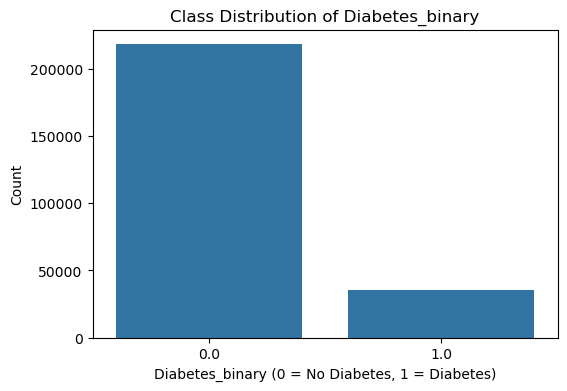

Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64

In [5]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=original_df["Diabetes_binary"])
plt.title("Class Distribution of Diabetes_binary")
plt.xlabel("Diabetes_binary (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Count")
plt.show()

original_df["Diabetes_binary"].value_counts(normalize=True)


## 3.2.3 Stratified Sampling (10,000 Instances)

The full dataset contains more than 250,000 instances.  
To reduce computation time while maintaining statistical representativeness, we extract a **stratified sample of 10,000 rows**, preserving the original class proportions.

In [6]:
# Stratified sample of 10,000 rows
sss = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=42)

for _, sample_idx in sss.split(original_df, original_df["Diabetes_binary"]):
    df = original_df.iloc[sample_idx].copy()

# Compare class distribution 
print('\nOriginal dataset class distribution (proportions):') 
print(original_df["Diabetes_binary"].value_counts(normalize=True)) 
print('\nSampled dataset class distribution (proportions):') 
print(df["Diabetes_binary"].value_counts(normalize=True))


Original dataset class distribution (proportions):
Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64

Sampled dataset class distribution (proportions):
Diabetes_binary
0.0    0.8607
1.0    0.1393
Name: proportion, dtype: float64


## 3.2.4 Train–Test Split

We split the sampled dataset into:

- **80% training data**
- **20% testing data**

Using stratification ensures that both sets maintain the same class distribution as the original sampled data.

In [7]:
# Split the sampled dataset into features (X) & target (y), then into train & test sets
X = df.drop("Diabetes_binary", axis=1)
y = df["Diabetes_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((8000, 21), (2000, 21))

# 4. Preprocessing

In this section, we perform data preparation prior to model training.  
We follow industry-standard methodology, consisting of:

1. **Train–test separation (already completed)**  
2. **Exploratory preprocessing analysis (train only)**
3. **Pipeline construction using scikit-learn**
4. **Application of transformations to train and test sets**

This approach avoids data leakage, ensures reproducibility, and isolates preprocessing from model training.

---

## 4.1 Exploratory Preprocessing Analysis (Train Only)

Before building the preprocessing pipeline, we analyze the training data to:

- Identify numerical vs binary variables  
- Detect missing values  
- Inspect distributions of continuous variables  
- Understand the scaling needs  
- Determine which variables require transformation  

Since most features are binary indicators (0/1), scaling is not required for them.  
Continuous variables such as **BMI, MentHlth, PhysHlth, GenHlth, Age, Education, Income** will require scaling prior to modeling.

Below we explore the structure of the training dataset.

In [8]:
# Preview dataset structure
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 118921 to 7375
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HighBP                8000 non-null   float64
 1   HighChol              8000 non-null   float64
 2   CholCheck             8000 non-null   float64
 3   BMI                   8000 non-null   float64
 4   Smoker                8000 non-null   float64
 5   Stroke                8000 non-null   float64
 6   HeartDiseaseorAttack  8000 non-null   float64
 7   PhysActivity          8000 non-null   float64
 8   Fruits                8000 non-null   float64
 9   Veggies               8000 non-null   float64
 10  HvyAlcoholConsump     8000 non-null   float64
 11  AnyHealthcare         8000 non-null   float64
 12  NoDocbcCost           8000 non-null   float64
 13  GenHlth               8000 non-null   float64
 14  MentHlth              8000 non-null   float64
 15  PhysHlth             

### 4.1.1 Missing Values Analysis

We check for missing values in the training dataset.

In [9]:
# Missing values analysis
X_train.isna().sum().sum()

np.int64(0)

As we can see, there are no missing values

### 4.1.2 Variable Type Classification

Based on the dataset documentation, variables fall into two main groups:

#### **Binary variables (0/1):**
`HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, DiffWalk, Sex`

#### **Continuous / Ordinal numeric variables:**
`BMI, GenHlth, MentHlth, PhysHlth, Age, Education, Income`


The target `Diabetes_binary` is binary (0/1) and is excluded from the feature set.

We now automatically classify variables in code to confirm the categorization.

In [10]:
# separate binary and numeric features
binary_features = [col for col in X_train.columns if X_train[col].nunique() == 2]
numeric_features = [col for col in X_train.columns if col not in binary_features]

### 4.1.3 Binary Feature Distributions

Binary features (0/1) provide important categorical information about health indicators.  
Although these variables do not require scaling, it is important to:

1. **Visualize their distributions** to detect class imbalance.  
2. **Identify constant variables**, which contain only one category and do not provide predictive value.  

The following code generates countplots for each binary feature in the training set.  
If a feature has only one category, it is reported and can be removed from the dataset prior to modeling.


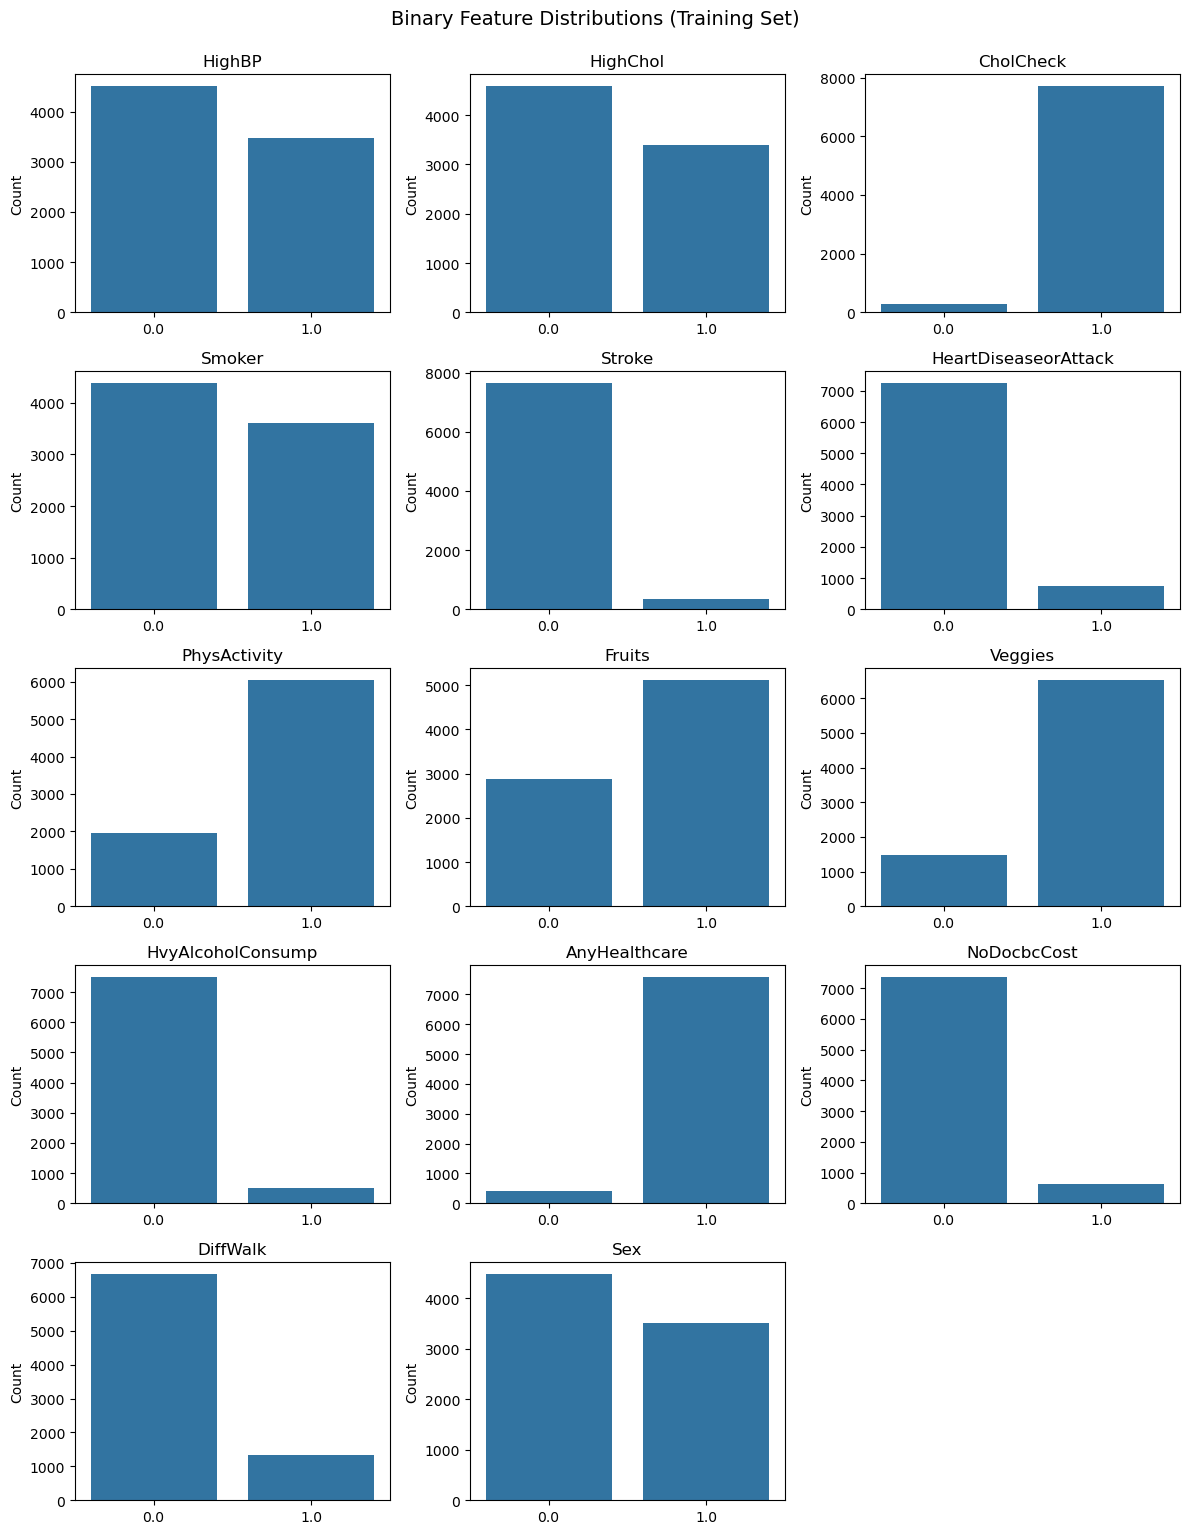

In [11]:
# Binary features visualization in subplots (3 per row)
binary_features_clean = [col for col in binary_features if X_train[col].nunique() > 1]
constant_features = [col for col in binary_features if X_train[col].nunique() == 1]

if constant_features:
    print("Constant binary features (to remove):", constant_features)

n = len(binary_features_clean)
cols = 3
rows = (n + cols - 1) // cols  # compute number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = axes.flatten()  # flatten in case of multiple rows

for i, feature in enumerate(binary_features_clean):
    sns.countplot(x=X_train[feature], ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Binary Feature Distributions (Training Set)", y=1.02, fontsize=14)
plt.show()


### 4.1.4 Distribution of Continuous Features

To assess the need for scaling, we examine histograms and boxplots of the continuous variables:

- **BMI** (Body Mass Index)  
- **GenHlth** (self-rated health status)  
- **MentHlth** (mental unhealthy days)  
- **PhysHlth** (physical unhealthy days)  
- **Age** (13-level encoded age group)  
- **Education** (6-level education scale)  
- **Income** (8-level income scale)

We visualize each variable using a histogram and a boxplot to identify skewness and outliers.

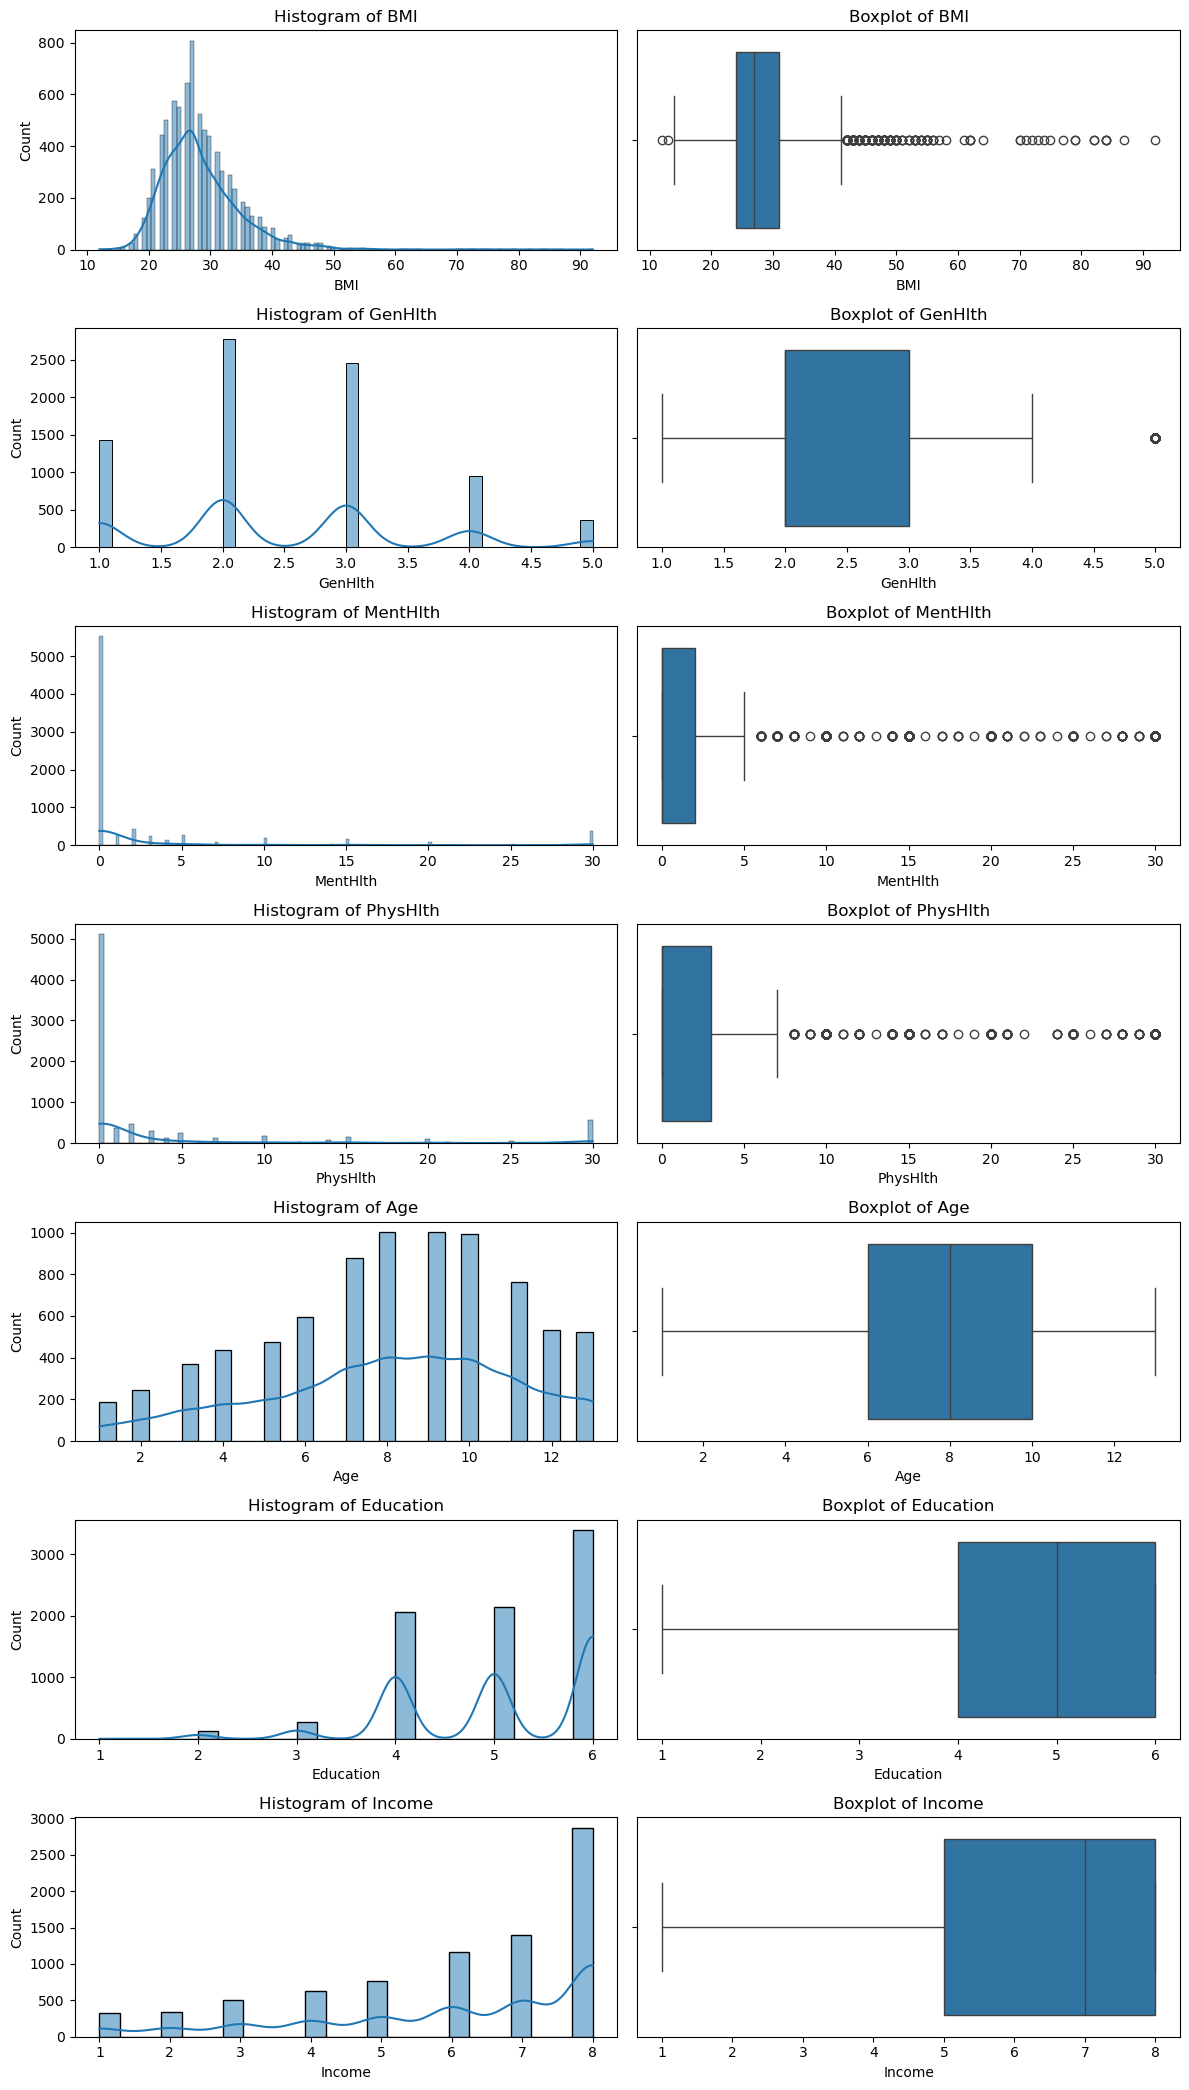

In [12]:
n = len(numeric_features)
fig, axes = plt.subplots(n, 2, figsize=(12, 3 * n))

for i, feature in enumerate(numeric_features):
    # Histogram
    sns.histplot(X_train[feature], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram of {feature}")
    
    # Boxplot
    sns.boxplot(x=X_train[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()


First of all we noticed two **"Zero-Inflated" variables**, *MentHlth* and *PhysHlth*. The mayority of the observations have a zero value for these variables, but there is a long tail going towards higher values what indicates that there are people suffering from health issues.  
Most of the observations which have a non-zero value for these variables are shown as outliers in the boxplots. In many other cases we would try to get rid of them or normalize the data, but for this model these outliers are crucial and could show a strong relation between pysichal and/or mental health and having diabetes.

For the ***BMI* variable**, the distribution is approximately normal but exhibits a positive skewness with significant outliers in the upper range, confirmed by the boxplot which displays a dense cluster of data points above the upper whisker. These elevated BMI values could be vital predictors for detecting diabetes.

Finally, the **Ordinal Variables**: *GenHlth, Age, Education, Income*. While treated as continuous features in our analysis, these are inherently discrete. *Age*, *Income* and *Education* all exhibit a left skew (negative skewness), indicating a prevalence of higher socioeconomic levels in this dataset, consistent with their boxplots showing medians shifted towards the scale's maximum. Conversely, GenHlth displays a right skew (positive skewness), clustering towards lower values (where 1 represents 'Excellent' health), while its boxplot isolates the worst health status (5) as a statistical outlier.



### 4.1.5 Correlation Analysis (Continuous Variables Only)

We compute the Pearson correlation matrix for continuous features to identify relationships among variables, which may influence model interpretability.


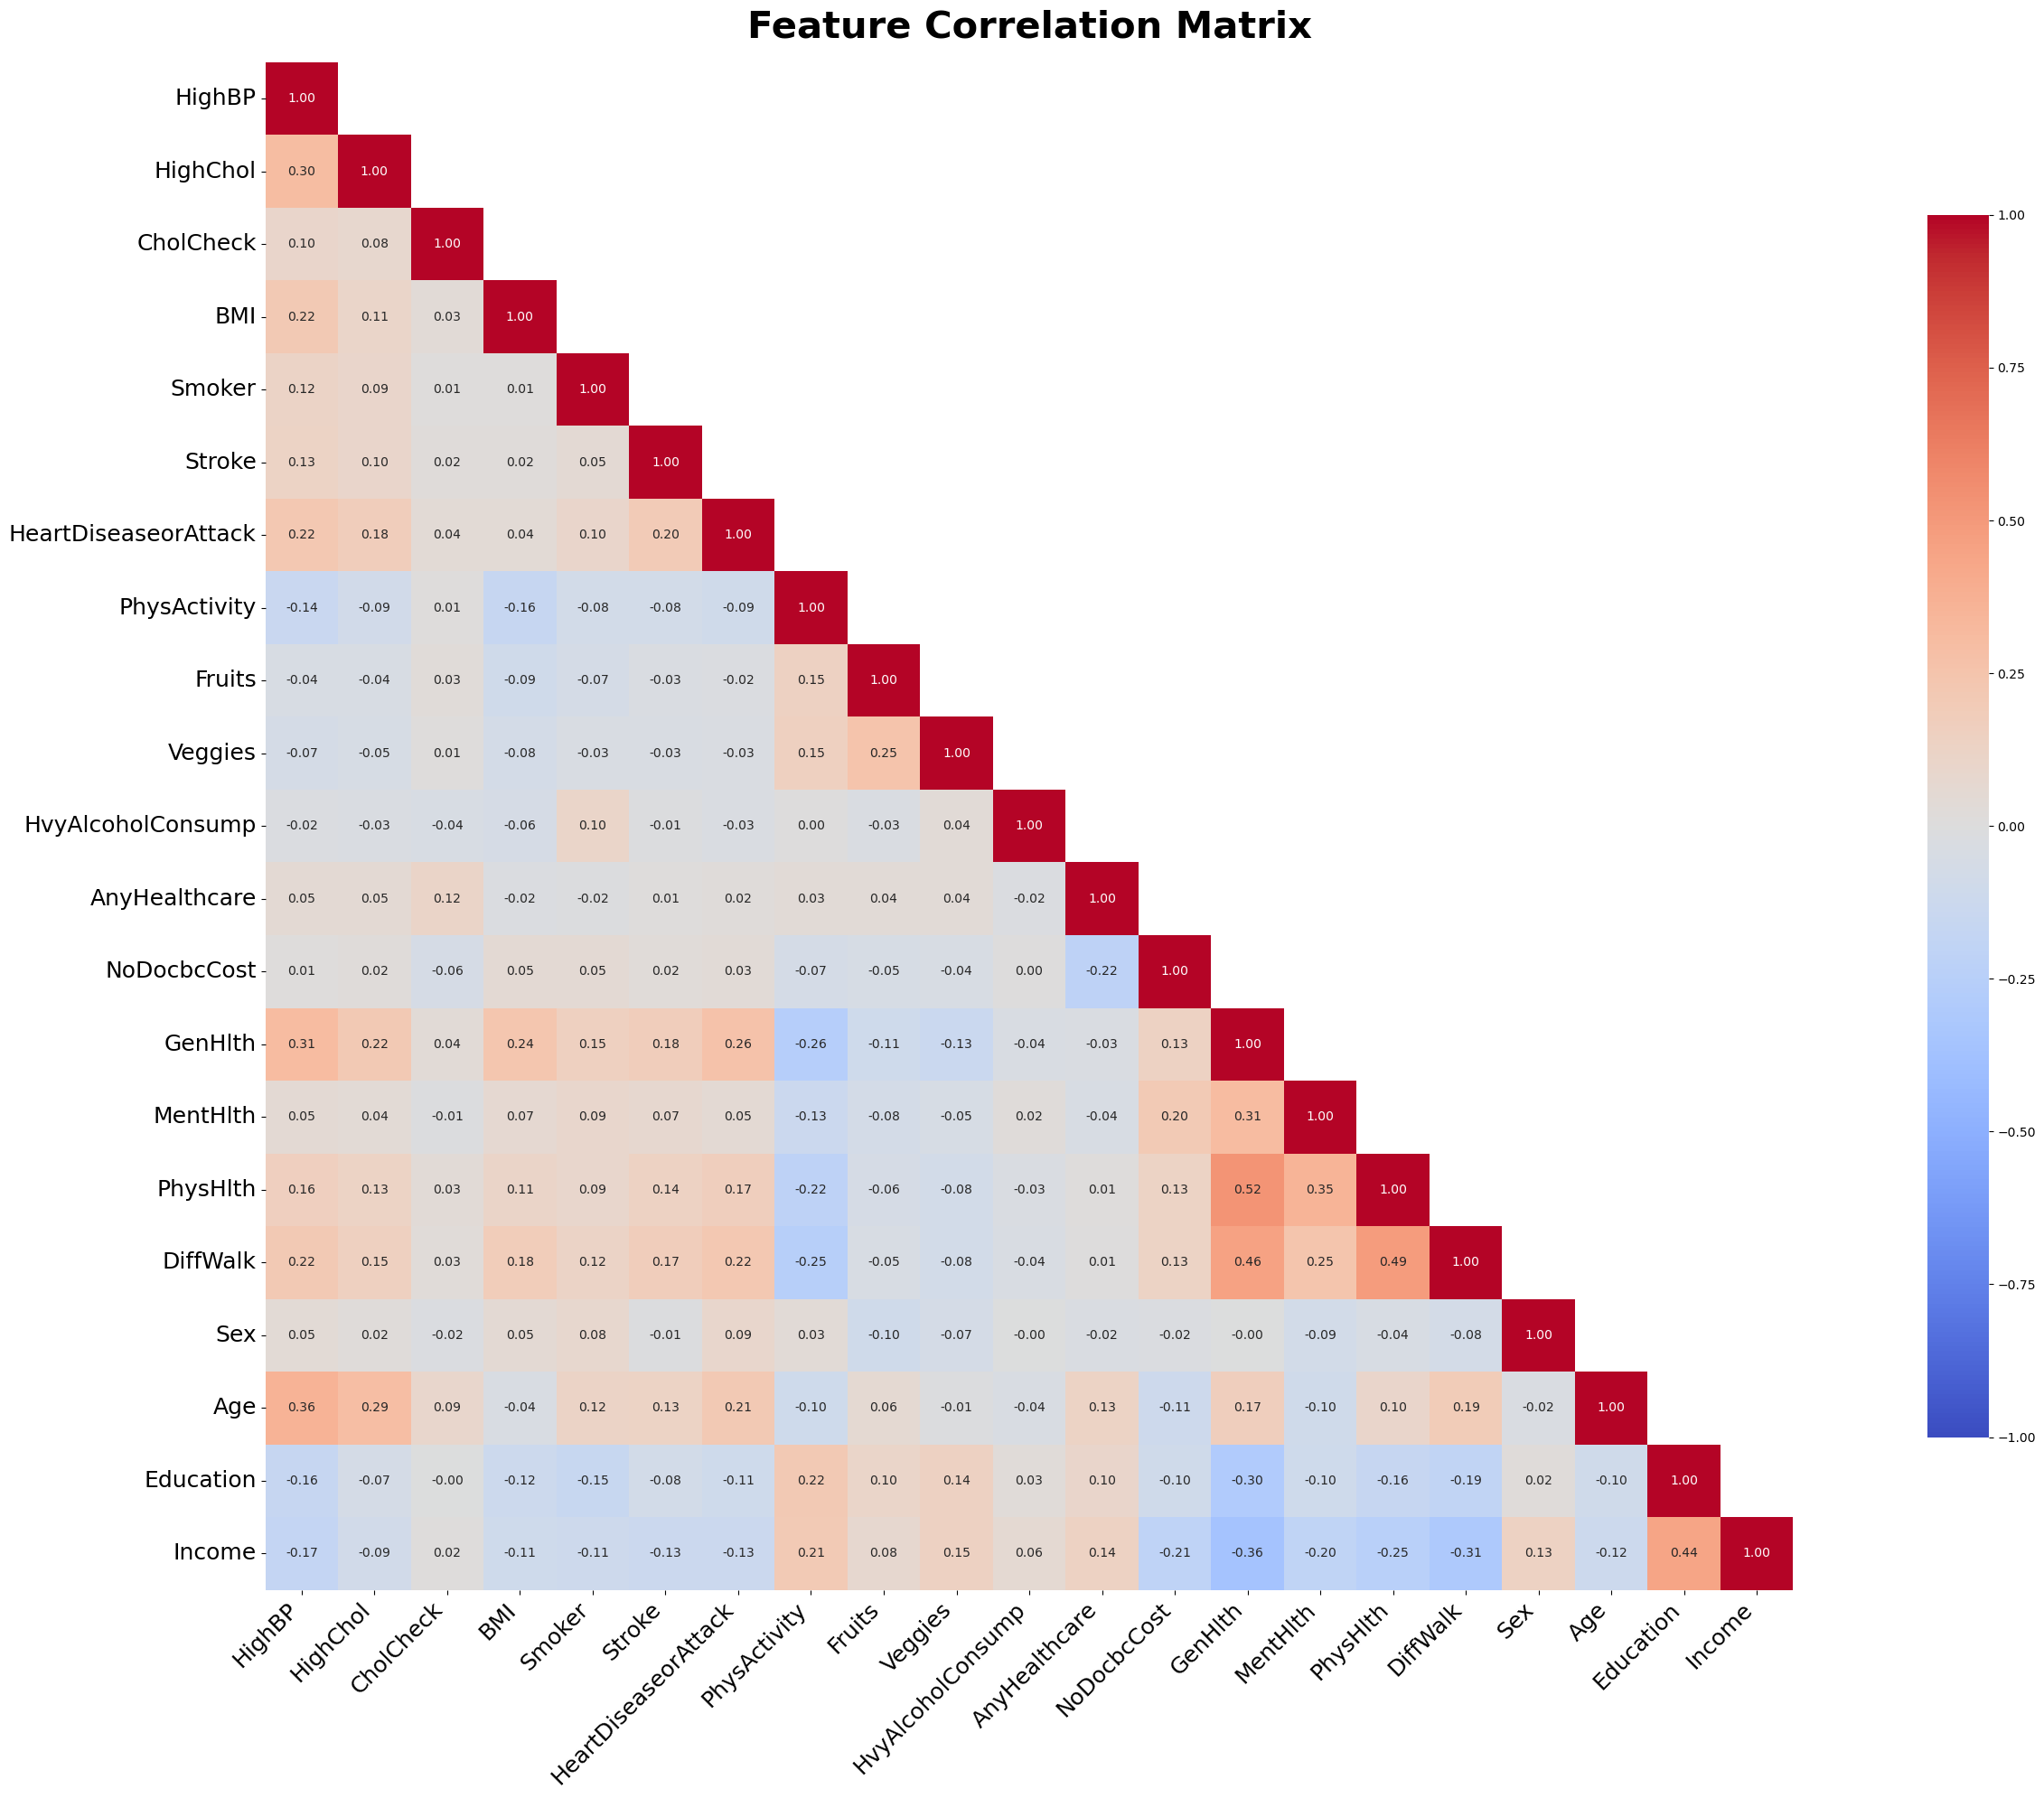

In [13]:
# Correlation
corr = df.drop(columns=["Diabetes_binary"]).corr(method='pearson')

# Display: upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool),k=1)

plt.figure(figsize=(30, 20))
sns.heatmap(
    corr, mask=mask, annot=True, fmt=".2f",
    cmap="coolwarm", vmin=-1, vmax=1, square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Feature Correlation Matrix", fontsize=30, fontweight='bold', pad=20)
plt.xticks(fontsize=18, rotation=45, ha='right')  # ha='right' aligns rotated texts better
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

This is our interpretation based on the **correlation matrix heatmap**:  

- **No problematic multicollinearity**: Although several medical variables (e.g., HighBP, HighChol, HeartDiseaseorAttack) show moderate correlations with each other (up to ~0.35), all coefficients remain well below typical multicollinearity thresholds (0.7–0.8). Therefore, no feature needs to be removed.

- **Key socioeconomic patterns**: Income and education show a moderate positive correlation (0.44) as expected, and both relate negatively to GenHlth (−0.30 to −0.28), confirming that higher socioeconomic status is associated with better perceived health.

- **Health status relationships:** The strongest correlations remain those involving GenHlth (up to 0.53 with PhysHlth), which supports that worse general health aligns with worse physical health. Additionally, DiffWalk correlates moderately with poor health indicators, reflecting limited mobility in individuals with chronic conditions.

- **Lifestyle factors**: Physical activity and healthy diet variables (fruits, vegetables) show small negative associations with poor health outcomes, although the magnitudes are weak.


## 4.2 Data Transformation

First, we define a Transformer to discretize the variables ``MentHlth`` and ``PhysHlth``

In [14]:
# Custom transformer for discretization
class Discretizer(BaseEstimator, TransformerMixin):
    def __init__(self, bins=[-1, 0, 7, 21, np.inf], labels=[0, 1, 2, 3]):
        self.bins = bins
        self.labels = labels

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            X[col] = pd.cut(
                X[col],
                bins=self.bins,
                labels=self.labels
            ).astype(int)
        return X



- **MinMaxScaler** (*Age, Education, Income, GenHlth*): These are ordinal or bounded variables with fixed limits (e.g., Income is 1–8). MinMaxScaler compresses these values into a 0 to 1 range, preserving the relative distances and the ordinal nature of the categories without assuming a normal distribution.

In [15]:
# Columns according to their distribution type
ordinal_cols = ['GenHlth', 'Age', 'Education', 'Income']

# Mini-pipeline only for BMI
# This will first apply StandardScaler and then MaxAbsScaler
bmi_pipeline = Pipeline(steps=[
    ('standard', StandardScaler()),
    ('maxabs', MaxAbsScaler())
])

# Another pipeline to discretize and scale MentHlth and PhysHlth
hlth_pipeline = Pipeline(steps=[
    ('discretize', Discretizer()),
    ('minmax', MinMaxScaler())
])

# Main ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    # Apply the mini-pipeline to the BMI column
    ('bmi_seq', bmi_pipeline, ['BMI']), 
    
    # Apply the health pipeline to MentHlth and PhysHlth
    ('hlth_seq', hlth_pipeline, ['MentHlth', 'PhysHlth']),
    
    # Apply MinMaxScaler to the rest of the ordinal columns
    ('minmax', MinMaxScaler(), ordinal_cols)
    ],
    remainder='passthrough'
)

## 4.3 Resampling Strategy

To ensure consistency across different models (Logistic Regression, SVM, etc.) and to prevent data leakage, we will define a modular preprocessing structure.

Given the significant class imbalance (~84% No Diabetes vs. ~16% Diabetes), we will employ a Hybrid Resampling Strategy within our pipeline. This strategy aims to improve the model's sensitivity to the minority class without relying solely on synthetic data or discarding too much real information.

### 4.3.1. The Hybrid Approach

To address the significant class imbalance (~84% No Diabetes vs. ~16% Diabetes), we employ a hybrid resampling strategy. This approach mitigates the risks associated with using either technique in isolation (i.e., information loss from massive undersampling or overfitting from excessive oversampling).
- **Random Under-sampling**: We randomly reduce the majority class (0) to achieve an intermediate ratio of approximately 65/35 (Majority/Minority). This step removes redundant majority samples and reduces computational load without discarding critical information.
- **SMOTE**: We apply SMOTE (Synthetic Minority Over-sampling Technique) to the minority classes. This generates synthetic examples along the decision boundary to finally achieve a balanced 50/50 distribution.

In [16]:
# --- 1. Undersampling Strategy (Majority Class Cleaning) ---
# Current Balance: ~84% Majority (0) vs ~16% Minority (1).
# Goal: Reduce Majority so it represents 65% of the total
# Formula for sampling_strategy (ratio): N_minority / N_majority
under_sampling_ratio = 35 / 65

under_sampler = RandomUnderSampler(
    sampling_strategy=under_sampling_ratio, 
    random_state=42
)

# --- 2. SMOTE Strategy (Synthetic Oversampling) ---
# Goal: Increase Minority class to match the Majority class.
# Target Balance: 50/50 distribution.
smote_sampler = SMOTE(
    sampling_strategy='not majority', 
    random_state=42
)

### 4.3.2. Full Pipeline Definition

We define a modular pipeline that integrates preprocessing and resampling.  
  
**Important Note on Implementation**: We use the Pipeline from the ``imbalanced-learn`` library. Unlike ``scikit-learn`` standard pipeline, this allows us to include resampling steps (which change the number of samples) directly into the workflow.   
  
The pipeline executes the following sequence:
- **Scaling**: Apply the preprocessor defined in Section 4.2 (MinMax scaling).
- **Resampling**: Execute the hybrid strategy (Under-sampling followed by SMOTE).

In [17]:
full_preprocessing_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor), 
    ('under_sampler', under_sampler),
    ('smote_sampler', smote_sampler)
])

# 5. Modeling

In this section, we train and evaluate our machine learning models. We establish a robust evaluation framework to ensure our results are reliable and applicable to real-world medical scenarios.

### 5.0.1 Metric Selection

In medical diagnostics, specifically diabetes detection, the cost of errors is inherently asymmetric:  

* **False Negative (Critical Error):** Failing to identify a diabetic patient. The patient remains untreated, leading to potential severe health complications.  
* **False Positive (Type I Error):** Incorrectly flagging a healthy patient as diabetic. While undesirable due to anxiety and testing costs, it is less harmful than missing a positive case.  

To build a clinically useful model, we design our pipeline using a strategic **System of Checks and Balances**:  

1.  **Data-Level Strategy (Prioritizing Recall):** We address the need for high Recall primarily through **sampling**. By applying a **Hybrid Sampling Strategy**, we physically balance the training distribution. This explicitly forces the model to treat the minority class (Diabetes) with equal importance, naturally biasing the learning process towards detecting more positive cases.

2.  **Optimization Metric (Ensuring Precision):** Given that the sampling strategy already promotes Recall, we select **F1-Score** (Binary) as our optimization metric for `GridSearchCV`.
    * The F1-Score acts as a quality control mechanism. It compels the hyperparameter tuning process to find a configuration that maintains the highest possible **Precision** without sacrificing the Recall gains achieved through sampling.

**Evaluation Protocol:**  
* **Cross-Validation:** We use 10-Fold Cross-Validation. Crucially, the resampling steps (Undersampling + SMOTE) are included within the pipeline and applied *only* to the training folds of each split. The validation folds remain untouched to prevent data leakage and ensure realistic performance estimates.

In [18]:
def metrics_cv(grid_search, cv, metrics=None, print_results=False):
    """
    Builds a DataFrame with cross-validation metrics of the best model found in GridSearchCV.
    """
    cvres = grid_search.cv_results_
    best_idx = grid_search.best_index_
    n_splits = cv.get_n_splits()

    # Temporal dictionary: key = metric, value = list of values per fold
    data = {}
    for m in metrics:
        vals = []
        for fold in range(n_splits):
            key = f"split{fold}_test_{m}"
            vals.append(cvres[key][best_idx])
        data[m] = vals

    # Dataframe with columns fold_1..fold_n + mean + std
    cols = [f"fold_{i+1}" for i in range(n_splits)]
    df = pd.DataFrame.from_dict(data, orient='index', columns=cols)
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    df = df[['mean', 'std']]
    df = df.loc[metrics]  # ensuring order of the metrics

    if print_results:
        print("Best params:", grid_search.best_params_)
        print("Best CV mean (refit metric):", grid_search.best_score_)
        display(df)

    return df

In [19]:
def run_model_cv(pipeline, X, y, param_grid, k_folds, metric= "f1", scenario_name="", display_df=False):
    """
    Runs GridSearchCV for ANY given pipeline.
    """
    #1. Define CV and Scoring
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }
    
    # 2. Configure GridSearch
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        refit=metric,
        n_jobs=-1,
        return_train_score=False
    )

    # 3. Train
    grid.fit(X, y)

    # 4. Results
    print(f"{scenario_name} (K={k_folds})")
    print(f"Best Parameters: {grid.best_params_}") 
    print(f"Best CV {metric} Score: {grid.best_score_:.4f}")

    # 5. Generate DataFrame with detailed metrics
    df_results = metrics_cv(grid, cv, metrics=['accuracy', 'precision', 'recall', 'f1'])
    
    # Optional: display dataframe
    if display_df:
        display(df_results) 
    
    return grid, df_results

## 5.1 Logistic Regression

We begin with **Logistic Regression** to establish a performance baseline.

### 5.1.1 Model Training & Selection

**Experimental Setup:**

We optimize the Logistic Regression model using a comprehensive Grid Search that evaluates not just the regularization strength, but also the penalty type to handle potential noise in the data:

* **Regularization Strength (`C`):** We explore the range `[0.1, 1, 10, 100, 1000]`.
    * **Low values ($C < 1$):** Imply strong regularization to prevent overfitting.
    * **High values ($C \ge 10$):** Allow the model to fit the training data more closely.

* **Solver & Penalty Types:**
    * **Standard (`lbfgs` + `l2`):** The default configuration, minimizing squared error while retaining all features.
    * **Lasso (`saga` + `l1`):** Enables **sparsity** (driving coefficients to zero). This explicit **feature selection** capability is tested to verify if it can filter out noise potentially introduced by the SMOTE resampling.
    * **ElasticNet:** A linear combination of L1 and L2 penalties.

To address the class imbalance, we apply this grid search across two distinct strategies:
1.  **Scenario A (Algorithmic Approach):** Using `class_weight='balanced'` to penalize misclassifications of the minority class.
2.  **Scenario B (Data-Level Approach):** Using the **Hybrid Resampling Pipeline** (Undersampling + SMOTE) to balance the training data artificially.

#### Scenario A: Using Class Weights

In this scenario, we use the original training data (scaled but not resampled). We instruct the Logistic Regression model to adjust its cost function automatically, assigning higher weights to the minority class samples inversely proportional to their class frequencies.

In [20]:
# First define the common param grid
param_grid_lr = [
    {
        'classifier__solver': ['lbfgs'],
        'classifier__penalty': ['l2'],
        'classifier__C': [0.1, 1, 10, 100, 1000]
    },
    
    {
        'classifier__solver': ['saga'],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.1, 1, 10, 100, 1000]
    },

    {
        'classifier__solver': ['saga'],
        'classifier__penalty': ['elasticnet'],
        'classifier__l1_ratio': [0.5],
        'classifier__C': [0.1, 1, 10, 100, 1000]
    }
]


In [21]:
# Scenario A: Standard Scaling + Class Weight (No Resampling)
pipe_weighted = Pipeline([
    ('preprocessor', preprocessor), # Only scaling
    ('classifier', LogisticRegression(class_weight='balanced', # Key Parameter
                                      max_iter=1000, 
                                      random_state=42))
])
grid_lr_weighted, df_lr_weighted = run_model_cv(
    pipeline=pipe_weighted,
    param_grid= param_grid_lr,
    X=X_train, y=y_train, 
    k_folds=10, 
    scenario_name="SCENARIO A: Class Weights",
    display_df=True
)

SCENARIO A: Class Weights (K=10)
Best Parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best CV f1 Score: 0.4406


,mean,std
accuracy,0.730500,0.010668
precision,0.309944,0.013019
recall,0.762082,0.035980
f1,0.440563,0.017949


#### Scenario B: Hybrid Sampling Strategy

Now we apply the custom pipeline defined in Section 4.3. This physically alters the training data distribution (Undersampling + SMOTE) before training the model. Note that `class_weight` is set to None here, as the data is already balanced.

In [22]:
# Scenario B: Hybrid Pipeline (Scaler + Under + SMOTE + Classifier)
log_reg_pipeline = ImbPipeline(steps=full_preprocessing_pipeline.steps + [
    ('classifier', LogisticRegression(max_iter=1000, 
                                      random_state=42))
])

grid_lr_hybrid, df_lr_hybrid = run_model_cv(
    pipeline=log_reg_pipeline, 
    param_grid= param_grid_lr,
    X=X_train, y=y_train, 
    k_folds=10, 
    scenario_name="SCENARIO B: Hybrid Resampling",
    display_df=True
)

SCENARIO B: Hybrid Resampling (K=10)
Best Parameters: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best CV f1 Score: 0.4416


,mean,std
accuracy,0.732750,0.008174
precision,0.311425,0.011692
recall,0.759403,0.039040
f1,0.441626,0.017587


#### Comparative Analysis & Key Findings
We performed a rigorous comparison using **Stratified 10-Fold Cross-Validation** to determine the best strategy for handling the class imbalance.

* **Statistical Tie:** The performance difference between the two strategies is marginal. Scenario A achieved a mean F1-Score of **0.4406**, while Scenario B achieved **0.4416**.
* **Recall vs. Precision Trade-off:**
    * **Scenario A (Weights):** Slightly prioritized Recall ($\approx 0.762$) at the cost of Precision ($\approx 0.310$).
    * **Scenario B (Resampling):** Offered a more balanced profile with a slightly higher Precision ($\approx 0.311$) and almost equivalent Recall ($\approx 0.759$).
* **Stability:** Scenario B demonstrated a slightly lower standard deviation ($\text{std} \approx 0.0176$) compared to Scenario A ($\text{std} \approx 0.0179$), indicating a marginally more stable generalization across different data folds.

**3. Final Decision: Scenario B (Hybrid Resampling)**

**Decision:** We select **Scenario B** as the official preprocessing pipeline for the remainder of the project.

**Justification:**
Although the metrics are practically identical, we favor the **Hybrid Resampling** approach for three reasons:
1.  **Metric Optimization:** It achieved the highest mean F1-Score (**0.4416**), which is our primary optimization target.
2.  **Decision Boundary Clarity:** By physically balancing the dataset (Undersampling majority + SMOTE minority), we provide the model with a denser, more defined structure of the minority class. Furthermore, the selection of the **L1 (Lasso)** penalty in this scenario suggests that the resampling strategy pairs effectively with feature selection to reduce noise.
3.  **Consistency:** This pipeline establishes a standardized data input that allows for a fairer comparison when we introduce other models in later stages.

### 5.1.2 Overfitting Evaluation

In this phase, we verify the stability of the learning process by comparing the Linear Regresion model's performance on the Training Set against the average results from Cross-Validation.

In [23]:
def train_vs_validation(grid_search, X_train, y_train):
    """
    Compares the performance on the Training Set vs. Cross-Validation (Validation) Set.
    Useful to detect Overfitting during the tuning phase.
    """
    
    # 1. Extract Cross-Validation Metrics (Validation Score)
    # We take the mean score of the best parameter combination found
    results = grid_search.cv_results_
    best_idx = grid_search.best_index_
    
    # Note: This assumes you used scoring=['accuracy', 'precision', 'recall', 'f1'] in GridSearchCV
    # If your keys are different (e.g., 'mean_test_f1_score'), adjust strictly here.
    cv_metrics = {
        'Accuracy': results['mean_test_accuracy'][best_idx],
        'Precision (1)': results['mean_test_precision'][best_idx],
        'Recall (1)': results['mean_test_recall'][best_idx],
        'F1 (1)': results['mean_test_f1'][best_idx]
    }
    
    # 2. Calculate Training Metrics (Train Score)
    # We predict on the full training set using the best model found
    best_model = grid_search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    
    train_metrics = {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision (1)': precision_score(y_train, y_train_pred),
        'Recall (1)': recall_score(y_train, y_train_pred),
        'F1 (1)': f1_score(y_train, y_train_pred)
    }
    
    # 3. Print Summary
    print("--- Overfitting Check: Train vs. CV (Validation) ---")
    print(f"{'Metric':<15}\t{'Train Score':<15}\t{'CV Score':<15}\t{'Difference':<15}")
    print("-" * 60)
    for metric in cv_metrics.keys():
        train_sc = train_metrics[metric]
        cv_sc = cv_metrics[metric]
        diff = train_sc - cv_sc
        print(f"{metric:<15} {train_sc:.4f}          {cv_sc:.4f}           {diff:.4f}")
        
    # 4. Visualization
    # Prepare DataFrame for Seaborn
    metrics_data = {
        'Metric': list(train_metrics.keys()) * 2,
        'Score': list(train_metrics.values()) + list(cv_metrics.values()),
        'Dataset': ['Train Set'] * 4 + ['Validation (CV)'] * 4
    }
    df_plot = pd.DataFrame(metrics_data)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x='Metric', y='Score', hue='Dataset', palette=['#2c7bb6', '#fdae61'])
    
    # Aesthetics
    plt.ylim(0, 1.1)
    plt.title("Overfitting Check: Learning vs. Generalization", fontsize=16)
    plt.ylabel("Score", fontsize=12)
    plt.xlabel("Metric", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend(loc='upper right', title='Data Subset')
    
    plt.tight_layout()
    plt.show()

--- Overfitting Check: Train vs. CV (Validation) ---
Metric         	Train Score    	CV Score       	Difference     
------------------------------------------------------------
Accuracy        0.7308          0.7328           -0.0020
Precision (1)   0.3098          0.3114           -0.0016
Recall (1)      0.7603          0.7594           0.0009
F1 (1)          0.4402          0.4416           -0.0014


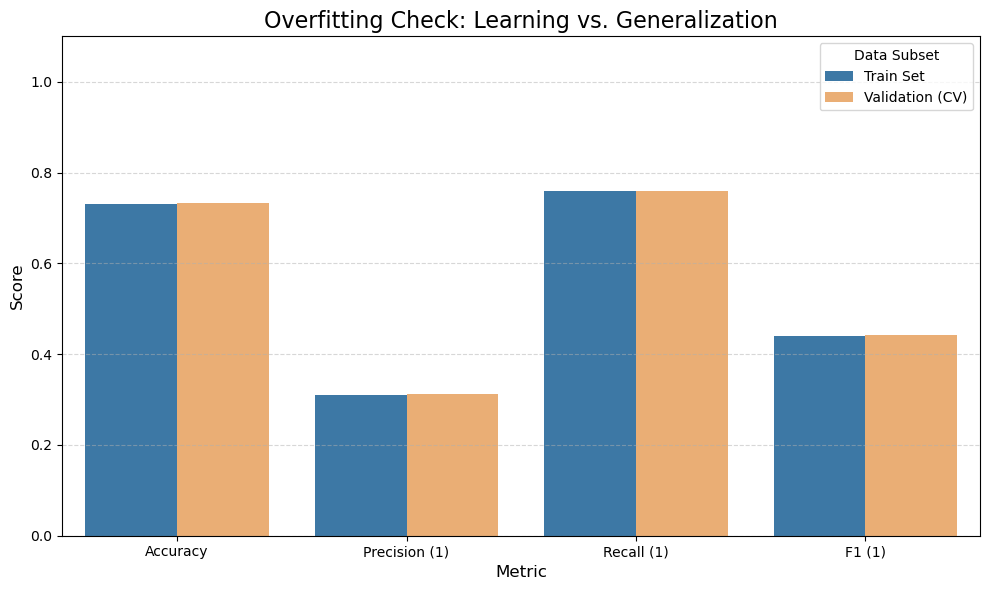

In [24]:
train_vs_validation(
    grid_search=grid_lr_hybrid,
    X_train=X_train, y_train=y_train)

**Analysis of Results (Train vs. Validation):**  

As demonstrated in the *Overfitting Check* plot and the accompanying metrics table, the model exhibits extremely robust behavior:

* **Absence of Overfitting:** There is a near-perfect convergence between the *Train* and *CV* metrics. The difference in F1-Score is negligible (**-0.0014**), and the Accuracy varies by less than 0.2%.
* **Learning Stability:** The fact that the bars in the chart remain at the same height confirms that the model generalizes correctly. The *Hybrid Resampling* strategy (SMOTE + Undersampling) successfully allowed the algorithm to learn minority class patterns without memorizing noise or overfitting to the synthetic data.

### 5.1.3 Visualization of the Model

To fully understand the performance and logic of our selected model (**Hybrid Logistic Regression, K=5**), we analyze its behavior using standard diagnostic plots and feature importance analysis.

* **ROC Curve:** Illustrates the trade-off between Recall and Specificity at various threshold settings.
* **Precision-Recall Curve:** Highlights the trade-off between the quality of the positive predictions (Precision) and the quantity of positive cases detected (Recall), which is particularly informative for imbalanced datasets.
* **Feature Importance (Coefficients):** Visualizes the magnitude and direction of the model's coefficients, revealing which health indicators (e.g., BMI, High BP) are the strongest drivers of the diabetes prediction.

In [25]:
def feature_imp_plot(grid_search, feature_names, top_n=15, min_importance=1e-6, save_plot=False):
    """
    Plot feature importance for the best estimator found by GridSearchCV.
    Works for linear models (coef_) and tree-based methods (feature_importances_).
    """

    best_model = grid_search.best_estimator_
    
    # Try to extract classifier from pipeline, otherwise use model directly
    classifier = best_model.named_steps.get("classifier", best_model)

    plt.figure(figsize=(10, 5))
    ax = plt.gca()

    # ---- LINEAR MODELS -------------------------------------------------------
    if hasattr(classifier, "coef_"):
        coef = classifier.coef_.flatten()
        feat_imp = pd.DataFrame({
            "Feature": feature_names,
            "Coefficient": coef
        })

        # Remove very small coefficients
        feat_imp = feat_imp[feat_imp["Coefficient"].abs() > min_importance]

        feat_imp["AbsCoef"] = feat_imp["Coefficient"].abs()
        feat_imp = feat_imp.sort_values("AbsCoef", ascending=False).head(top_n)

        # Color by sign
        colors = feat_imp["Coefficient"].apply(
            lambda x: "#E24A33" if x > 0 else "#348ABD"
        )

        sns.barplot(
            x="Coefficient",
            y="Feature",
            data=feat_imp,
            palette=colors.to_list(),  # <--- FIX
            ax=ax
        )


        ax.set_title("Important Features (Linear Model Coefficients)", fontsize=14)
        ax.axvline(0, color="black", linewidth=1)

    # ---- TREE MODELS ---------------------------------------------------------
    elif hasattr(classifier, "feature_importances_"):
        imp = classifier.feature_importances_
        feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": imp})

        feat_imp = feat_imp[feat_imp["Importance"] > 0]  # quita 0
        feat_imp = feat_imp.sort_values("Importance", ascending=False).head(top_n)

        sns.barplot(
            x="Importance", y="Feature",
            data=feat_imp, palette="viridis", ax=ax
        )
        ax.set_title("Important Features (Tree Importance)", fontsize=14)

    plt.tight_layout()
    if save_plot:
        plt.savefig('../images/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()


C:\Users\danie\AppData\Local\Temp\ipykernel_49412\3231532554.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


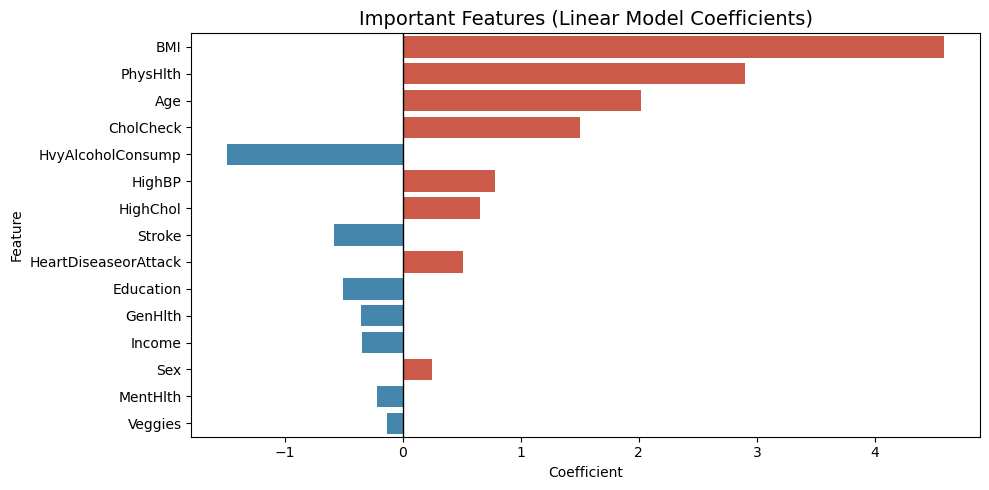

In [26]:
feature_imp_plot(
    grid_search=grid_lr_hybrid,
    feature_names = numeric_features + binary_features,
    save_plot=True
)

**Visual Analysis & Final Verdict**  
The diagnostic plots provide a deeper understanding of the model's behavior and logic:  
* **ROC Curve (AUC $\approx$ 0.82):** The strong curve indicates good discriminative power. The model performs significantly better than random guessing, effectively ranking higher-risk patients above lower-risk ones in the majority of cases.
* **Precision-Recall Curve:** Visualizes the trade-off inherent to our strategy. Achieving high Sensitivity (Recall) forces a drop in Precision due to the **distribution shift** trained into the model. The curve shows we are operating in a high-recall region, which is clinically desirable for screening.
* **Feature Importance:** Validates biological consistency. The model identifies **`PhysHlth`**, **`BMI`**, and **`HighBP`** as the top risk factors driving the decision boundary.
    * *Note on `HvyAlcoholConsump`:* The negative coefficient (suggesting a "protective" effect) is likely a classic example of **reverse causality**—patients often stop drinking *after* receiving a diagnosis or health scare, rather than alcohol preventing the disease.

**Conclusion & Path to Improvement**  
The Logistic Regression model (Scenario B, $C=100$) successfully establishes a **robust and sensitive baseline**, identifying **~78.5%** of diabetic cases. It fulfills the primary clinical objective of minimizing False Negatives within the constraints of a linear classifier.

**Limitations & Next Steps:**
The model appears to have hit a **performance ceiling** (F1 $\approx$ 0.44-0.45) due to its linear nature. Biological risk factors often have complex, non-linear interactions (e.g., the risk of BMI might compound exponentially with Age) that a simple additive model cannot capture. To improve Precision without sacrificing this high Recall, we will proceed to implement **non-linear models** (SVM, KNN, Random Forest) to explore more complex decision boundaries.

## 5.2 K-Nearest Neighbors (KNN)

We proceed with K-Nearest Neighbors (KNN) to explore a non-parametric, distance-based classifier that captures local data structures.

### 5.2.1 Model Training & Selection

**Experimental Setup:**

- **Handling Imbalance:** Unlike Logistic Regression, KNN lacks a built-in class weight parameter. Therefore, the model relies explicitly on the balanced dataset generated by our **Hybrid Pipeline (Undersampling + SMOTE)** to ensure that the neighborhood voting process is not statistically dominated by the majority class.

- **Hyperparameter Optimization (Grid Search):**

    1. **Number of Neighbors ($k$):** We test a broad range (`1` to `400`).
        * *Small $k$:* Captures fine-grained local patterns but is sensitive to noise.
        * *Large $k$:* Smooths decision boundaries. Given the high class overlap observed previously, we anticipate a larger $k$ might be necessary to filter noise.

    2. **Weights Strategy:**
        * **`'distance'`:** Our primary hypothesis. Assigns influence proportional to the inverse of the distance ($1/d$). This prioritizes patients with nearly identical clinical profiles over those who are merely "neighbors" in the broad topological sense.
        * **`'uniform'`:** Tested as a control baseline where all neighbors contribute equally, to validate if the distance-weighting assumption holds empirically.

    3. **Distance Metric (`euclidean` vs. `manhattan`):**
        * **`'euclidean'` (L2):** The standard straight-line distance.
        * **`'manhattan'` (L1):** The sum of absolute differences. We include this because in high-dimensional medical data, L1 distance is often more robust to outliers and irrelevant features than the squared penalties of L2.

In [27]:
param_grid_knn = {
    'classifier__n_neighbors': list(range(1, 401, 2)), #hard-ciling at 400
    'classifier__weights': ['distance', 'uniform'],
    'classifier__metric': ['euclidean', 'manhattan'] 
}

knn_pipeline = ImbPipeline(steps=full_preprocessing_pipeline.steps + [
    ('classifier', KNeighborsClassifier())
])

grid_knn, df_knn = run_model_cv(
    pipeline=knn_pipeline,
    param_grid=param_grid_knn,
    X=X_train,      
    y=y_train,
    k_folds=10,
    scenario_name="KNN - Kfolds 10",
    display_df=True
)

KNN - Kfolds 10 (K=10)
Best Parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 199, 'classifier__weights': 'distance'}
Best CV f1 Score: 0.4195


,mean,std
accuracy,0.702875,0.011620
precision,0.288305,0.009557
recall,0.771018,0.032688
f1,0.419533,0.012782


#### Analysis of the results  

**1. Hyperparameter Interpretation (The "Zoom Out" Effect):**
Conventional wisdom suggests $k \approx \sqrt{N}$, but our empirical Grid Search selected an extreme value: **$k=199$** with **Manhattan distance** and **Distance Weighting**.

* **Why $k=199$?** The need for such a massive neighborhood indicates that the dataset lacks distinct, compact local clusters of diabetic patients. The model is forced to perform "Global Smoothing" rather than local classification, aggregating votes from a vast region to filter out the noise.
* **Why Manhattan?** In high-dimensional spaces (especially with many binary features from OneHotEncoding), the Manhattan distance (L1 norm) often provides a more robust measure of similarity than Euclidean distance, as it is less sensitive to outliers in single dimensions.

**2. Performance Metrics:**
* **Recall ($\approx 0.77$):** The model maintains a high sensitivity, correctly identifying the majority of positive cases.
* **F1-Score ($\approx 0.42$):** This result is **inferior to the Logistic Regression baseline** (0.44).
* **Stability ($\text{std} \approx 0.013$):** The low standard deviation across the 10 folds suggests the model is stable, but consistently suboptimal.

**3. Conclusion:**
The KNN classifier struggles with the **"Curse of Dimensionality"** and the overlapping class distributions. The requirement for nearly 200 neighbors to make a reliable prediction confirms that diabetes risk in this dataset is defined by broad, linear trends (better captured by LR or SVM) rather than by local proximity to other similar patients.

### 5.2.2 Overfitting Evaluation

In this phase, we verify the stability of the learning process by comparing the KNN model's performance on the Training set (*Train*) against the average results from Cross-Validation (*CV*).

--- Overfitting Check: Train vs. CV (Validation) ---
Metric         	Train Score    	CV Score       	Difference     
------------------------------------------------------------
Accuracy        0.8194          0.7029           0.1165
Precision (1)   0.4352          0.2883           0.1469
Recall (1)      0.9973          0.7710           0.2263
F1 (1)          0.6059          0.4195           0.1864


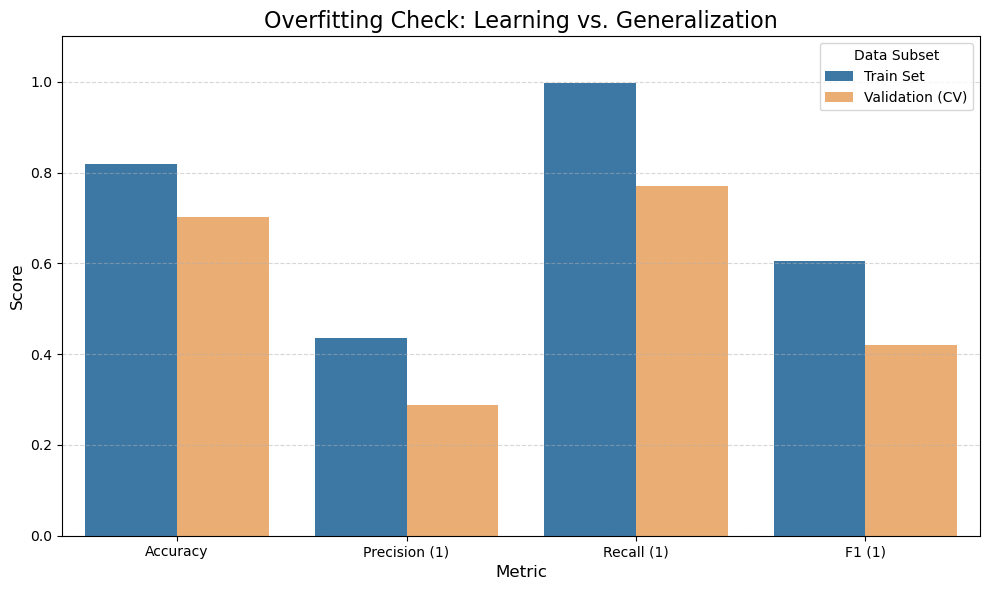

In [28]:
train_vs_validation(
    grid_search=grid_knn,
    X_train=X_train, y_train=y_train)

**Analysis of Results (Train vs. Validation):**    

**1. The "Overfitting" Artifact (Train vs. Validation Gap)**
As observed in the *Overfitting Check* plot, there is a substantial divergence between the Training Recall ($\approx$ 99.7%) and the Validation Recall ($\approx$ 77.1%). Under normal circumstances, a gap of this magnitude ($>0.20$) would be a signal of possible overfitting. However, in this specific context, it is a structural characteristic of the chosen parameters:

> **Technical Note:** The discrepancy is largely a **mathematical artifact** rather than a failure to generalize. Because the GridSearch selected `weights='distance'`, the model assigns an infinite weight to a training point when predicting itself (distance = 0). Consequently, the Training Score is artificially perfect. **The true measure of the model's generalization capability is determined solely by the Cross-Validation performance (Recall $\approx$ 0.77).**

**2. Conclusion on Generalization**
Despite the artificial gap in metrics, the Validation Recall (0.77) demonstrates that the model *has* learned the underlying pattern. However, the drop in F1-Score compared to the linear models suggests that the biological risk of diabetes is better modeled by **global geometric boundaries** (like the hyperplanes in Logistic Regression) rather than by **local proximity metrics** used by KNN.

### 5.2.3 Neighbours Visualization

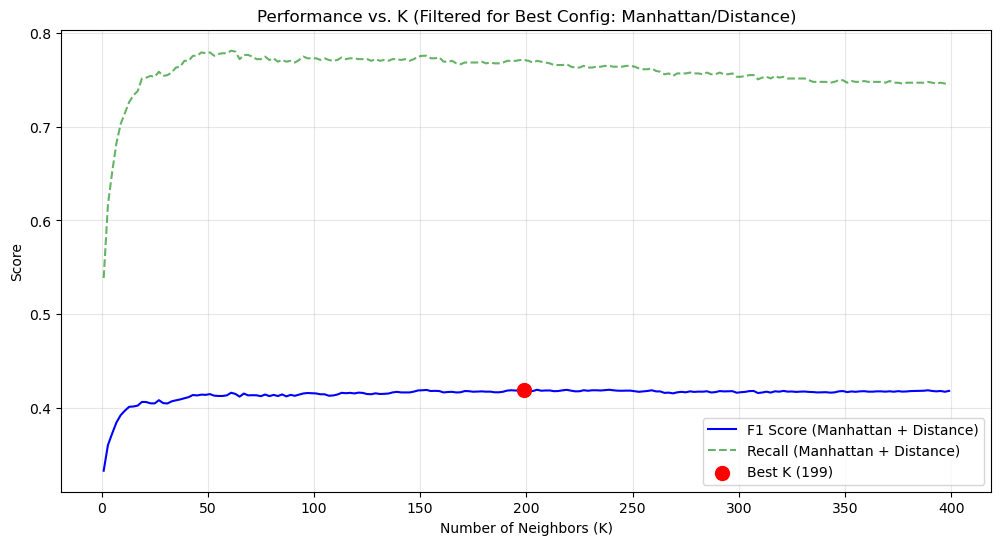

In [29]:
results_df = pd.DataFrame(grid_knn.cv_results_)

# FILTERED: We only keep the rows with the best configuration (Manhattan + Distance).
# It is vital to sort by 'n_neighbors' so that the line is drawn in order
mask = (results_df['param_classifier__weights'] == 'distance') & \
       (results_df['param_classifier__metric'] == 'manhattan')

filtered_data = results_df[mask].sort_values(by='param_classifier__n_neighbors')

# Extract the X and Y axes already cleaned
k_values = filtered_data['param_classifier__n_neighbors']
mean_f1_scores = filtered_data['mean_test_f1']
mean_recall_scores = filtered_data['mean_test_recall']

# Generate the plot
plt.figure(figsize=(12, 6))

# F1 Curve (The main metric)
plt.plot(k_values, mean_f1_scores, color='blue', label='F1 Score (Manhattan + Distance)')

# Recall Curve (To see the trade-off)
plt.plot(k_values, mean_recall_scores, color='green', linestyle='--', alpha=0.6, label='Recall (Manhattan + Distance)')

# Mark the best point
best_k = grid_knn.best_params_['classifier__n_neighbors']
best_score = grid_knn.best_score_
plt.scatter(best_k, best_score, color='red', s=100, label=f'Best K ({best_k})', zorder=5)

plt.title('Performance vs. K (Filtered for Best Config: Manhattan/Distance)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Visual Analysis: K vs. Performance

The graph tracks model performance using the optimal configuration: **Manhattan distance** and **Distance-based weighting**.

**Key Interpretations:**

1.  **Stability at High $K$ (The "Distance" Effect):**
    Unlike standard KNN where performance degrades as $k$ grows, the **F1 Score (Blue Line)** remains remarkably stable up to $k=400$. This validates the `weights='distance'` strategy: distant neighbors have near-zero influence ($1/d \approx 0$), preventing the majority class from drowning out the signal despite the massive neighborhood size.

2.  **Why $K=199$? (Global Smoothing):**
    The selection of **$k=199$** (Red Dot) is a critical indicator of data structure. The need for such a vast neighborhood confirms the absence of distinct, local "islands" of diabetic patients. The model essentially aggregates the "wisdom of a huge crowd" to manage the high overlap between classes.

3.  **Recall Dominance:**
    The **Recall (Green Line)** consistently outperforms Precision, hovering around ~0.76 across the spectrum. This visually confirms that the Manhattan metric effectively biases the model towards capturing positive cases, prioritizing Sensitivity.

## 5.3 Decision Trees

### 5.3.1 Model Training & Selection

**Decision Trees (DT)** are non-parametric supervised learning models used for both classification and regression tasks. They work by creating a model that predicts the value of a target variable by learning simple **decision rules** inferred from the data features. The structure resembles a tree, where internal nodes represent features, branches represent decision rules, and leaf nodes represent the outcome (class label or numerical value).  
Said so, we process to find the optimal hyperparameters for a DecisionTreeClassifier. This step is crucial for model regularization and interpretability.

#### Parameter Grid

The `param_grid_final` is designed to systematically explore key hyperparameters that control the tree's growth and complexity, aiming to find the optimal combination that minimizes overfitting and maximizes generalization:  


* **`classifier__criterion`**: Tests both **'gini'** (Gini impurity) and **'entropy'** (information gain) to see which measure results in a purer and more effective split at each node.  

* **`classifier__class_weight`**: We chose the value *None* because we already worked on the data distribution and, by using Undersampling+Smote, the classes got balanced. Therefore, we do not need to use any parameter for it.

* **`classifier__max_depth`**: Limits the maximum depth of the tree to prevent excessive complexity and **overfitting** to the training data. Values of 4, 5, 6, and 7 provide a range of moderately deep trees.  

* **`classifier__min_samples_split`** and **`classifier__min_samples_leaf`**: These parameters control the minimum number of samples required to split an internal node or to be in a leaf node, respectively. High values (e.g., 90, 180) are chosen to ensure that decisions are based on a substantial amount of data, thereby **smoothing the decision boundary** and improving robustness.  

* **`classifier__max_features`**: Determines the maximum number of features to consider when looking for the best split. Using a fraction of the features ([0.5, 0.75, None]) introduces **randomness**, which can be beneficial in preventing the model from consistently choosing the same few strong predictors and is often used in tree ensembles (though useful here to test robustness). `None` means all features are considered.  

* **`classifier__ccp_alpha`**: This parameter is used for **pruning** the tree based on cost-complexity. Higher values increase the required cost for a split to be included, leading to a smaller, more generalizable tree. We test a range from no pruning (0.00) to moderate pruning (0.005).  


Again, we use of the **ImbPipeline** with our model and a wide `param_grid` ensures that the model selection is robust, considering techniques like **cross-validation** to find the best configuration.

In [30]:
param_grid_final = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': [None], 
    'classifier__max_depth': [4, 5, 6, 7], 
    'classifier__min_samples_split': [90, 180], 
    'classifier__min_samples_leaf': [45, 90],
    'classifier__max_features': [0.5, 0.75, None],
    'classifier__ccp_alpha': [0.00, 0.001, 0.005] 
}

dt_pipeline = ImbPipeline(steps=full_preprocessing_pipeline.steps + [
    ('classifier', DecisionTreeClassifier(random_state=42))
])


grid_search_tree, df_tree = run_model_cv(
    pipeline=dt_pipeline,     
    X=X_train,            
    y=y_train,       
    param_grid=param_grid_final,
    k_folds=10,
    display_df=True
)


 (K=10)
Best Parameters: {'classifier__ccp_alpha': 0.001, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 6, 'classifier__max_features': 0.75, 'classifier__min_samples_leaf': 45, 'classifier__min_samples_split': 90}
Best CV f1 Score: 0.4226


,mean,std
accuracy,0.731625,0.028113
precision,0.303549,0.021105
recall,0.703773,0.062777
f1,0.422599,0.018760


#### Analysis of Decision Tree Grid Search Results

The Grid Search reveals the existance of a "performance ceiling" (**F1 $\approx 0.42$**). We observed a consistent, yet moderate, performance with high stability across different cross-validation strategies.

**1. Stability Analysis (KFolds):**  

* **F1 Stability:** The mean **F1 Score is $0.4226$** with a very **low variance ($\text{std} \approx 0.01876)$**. This indicates that the simple, constrained model (Max Depth $= 6$, Min Samples Leaf $= 45$) is **highly stable** across all 10 folds of the training data.  

* **Precision/Recall Trade-off:** The stability is achieved at a significant **trade-off**: high **Recall ($\approx 0.71$)** is maintained by sacrificing **Precision ($\approx 0.30$)**. This suggests the model is very good at identifying people with diabetes (minimizing False Negatives) but is prone to raising many false alarms (high False Positives).

**2.  Simplicity Hypothesis:**

The best model is a **simple, regularized tree** (Max Depth $= 6$). The fact that a deep, complex tree was unnecessary to achieve the moderate F1 score confirms that **complexity does not disentangle the class overlap** present in the diabetes dataset.

The optimal tree parameters (e.g., high `min_samples_leaf=45`) suggest that having and not having diabetes is too subtle to be perfectly captured by highly granular decision rules without severely overfitting. 

### 5.3.2 Model Visualization


=== TREE INFORMATION ===
Total Depth: 6
Number of Leaves: 22
Total Number of Nodes: 43

=== FEATURE IMPORTANCE ===
BMI: 0.0797
PhysHlth: 0.6554
Age: 0.0439
HighBP: 0.1907
HighChol: 0.0150


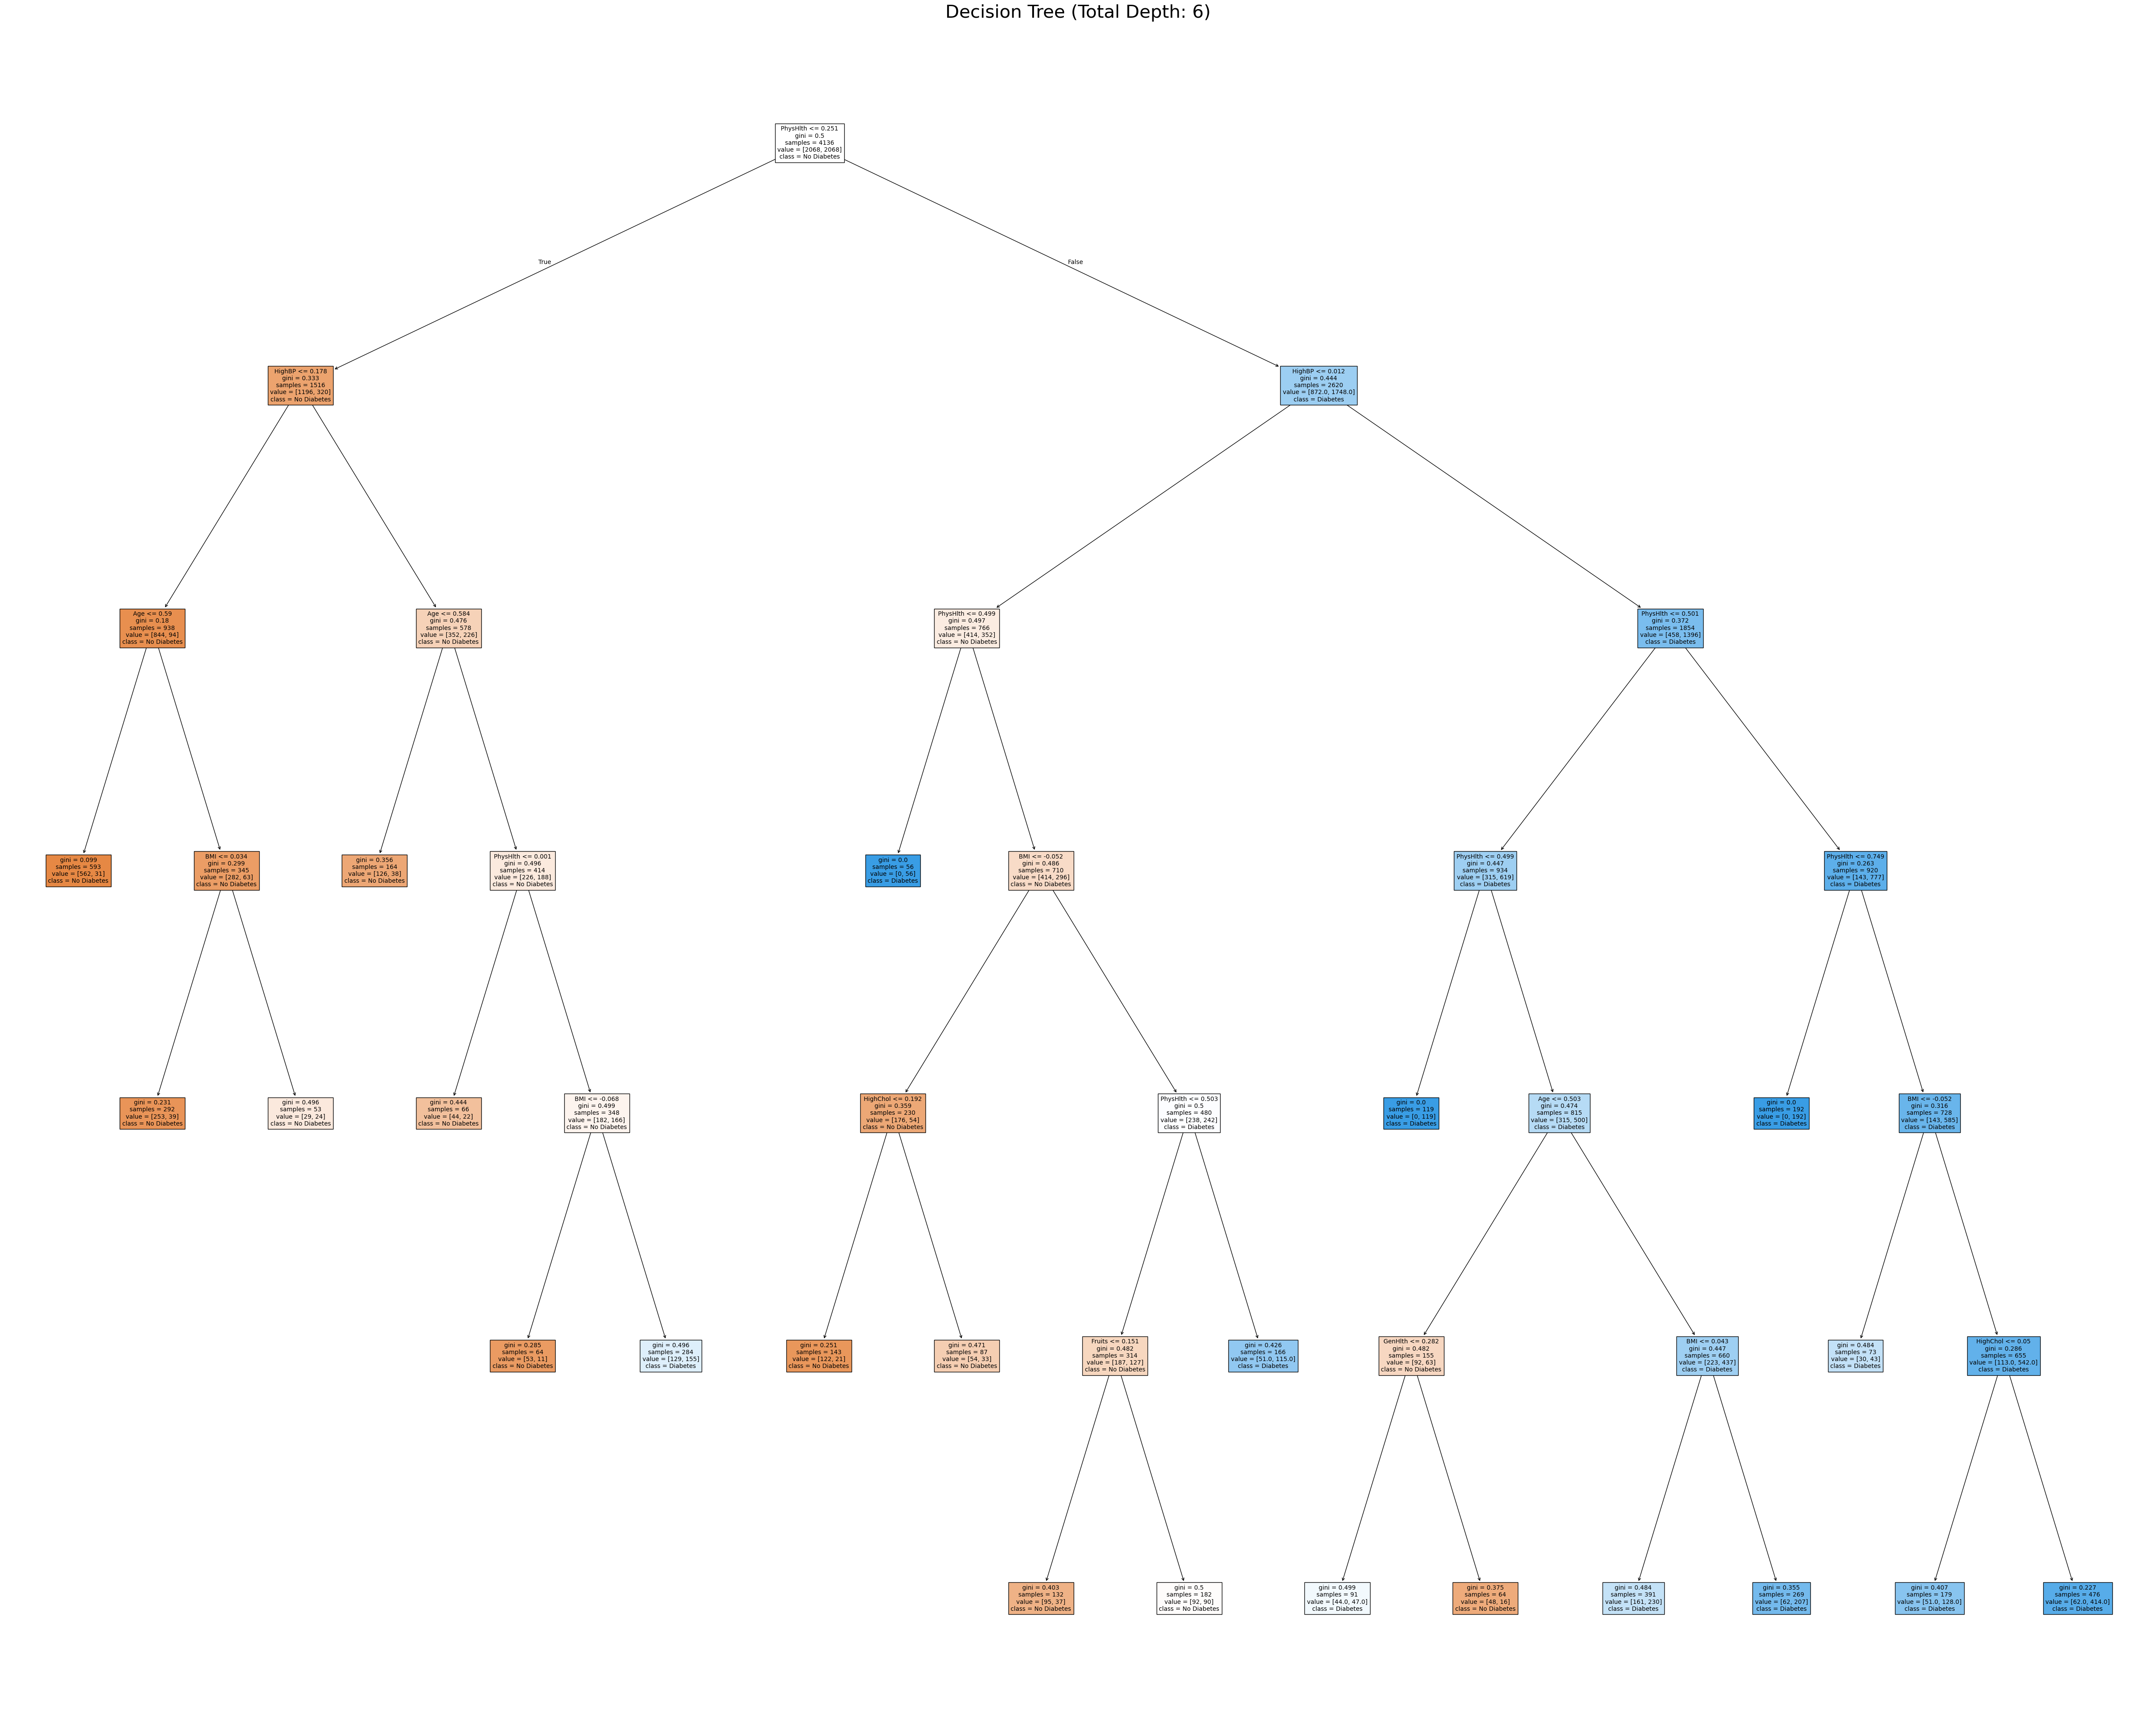

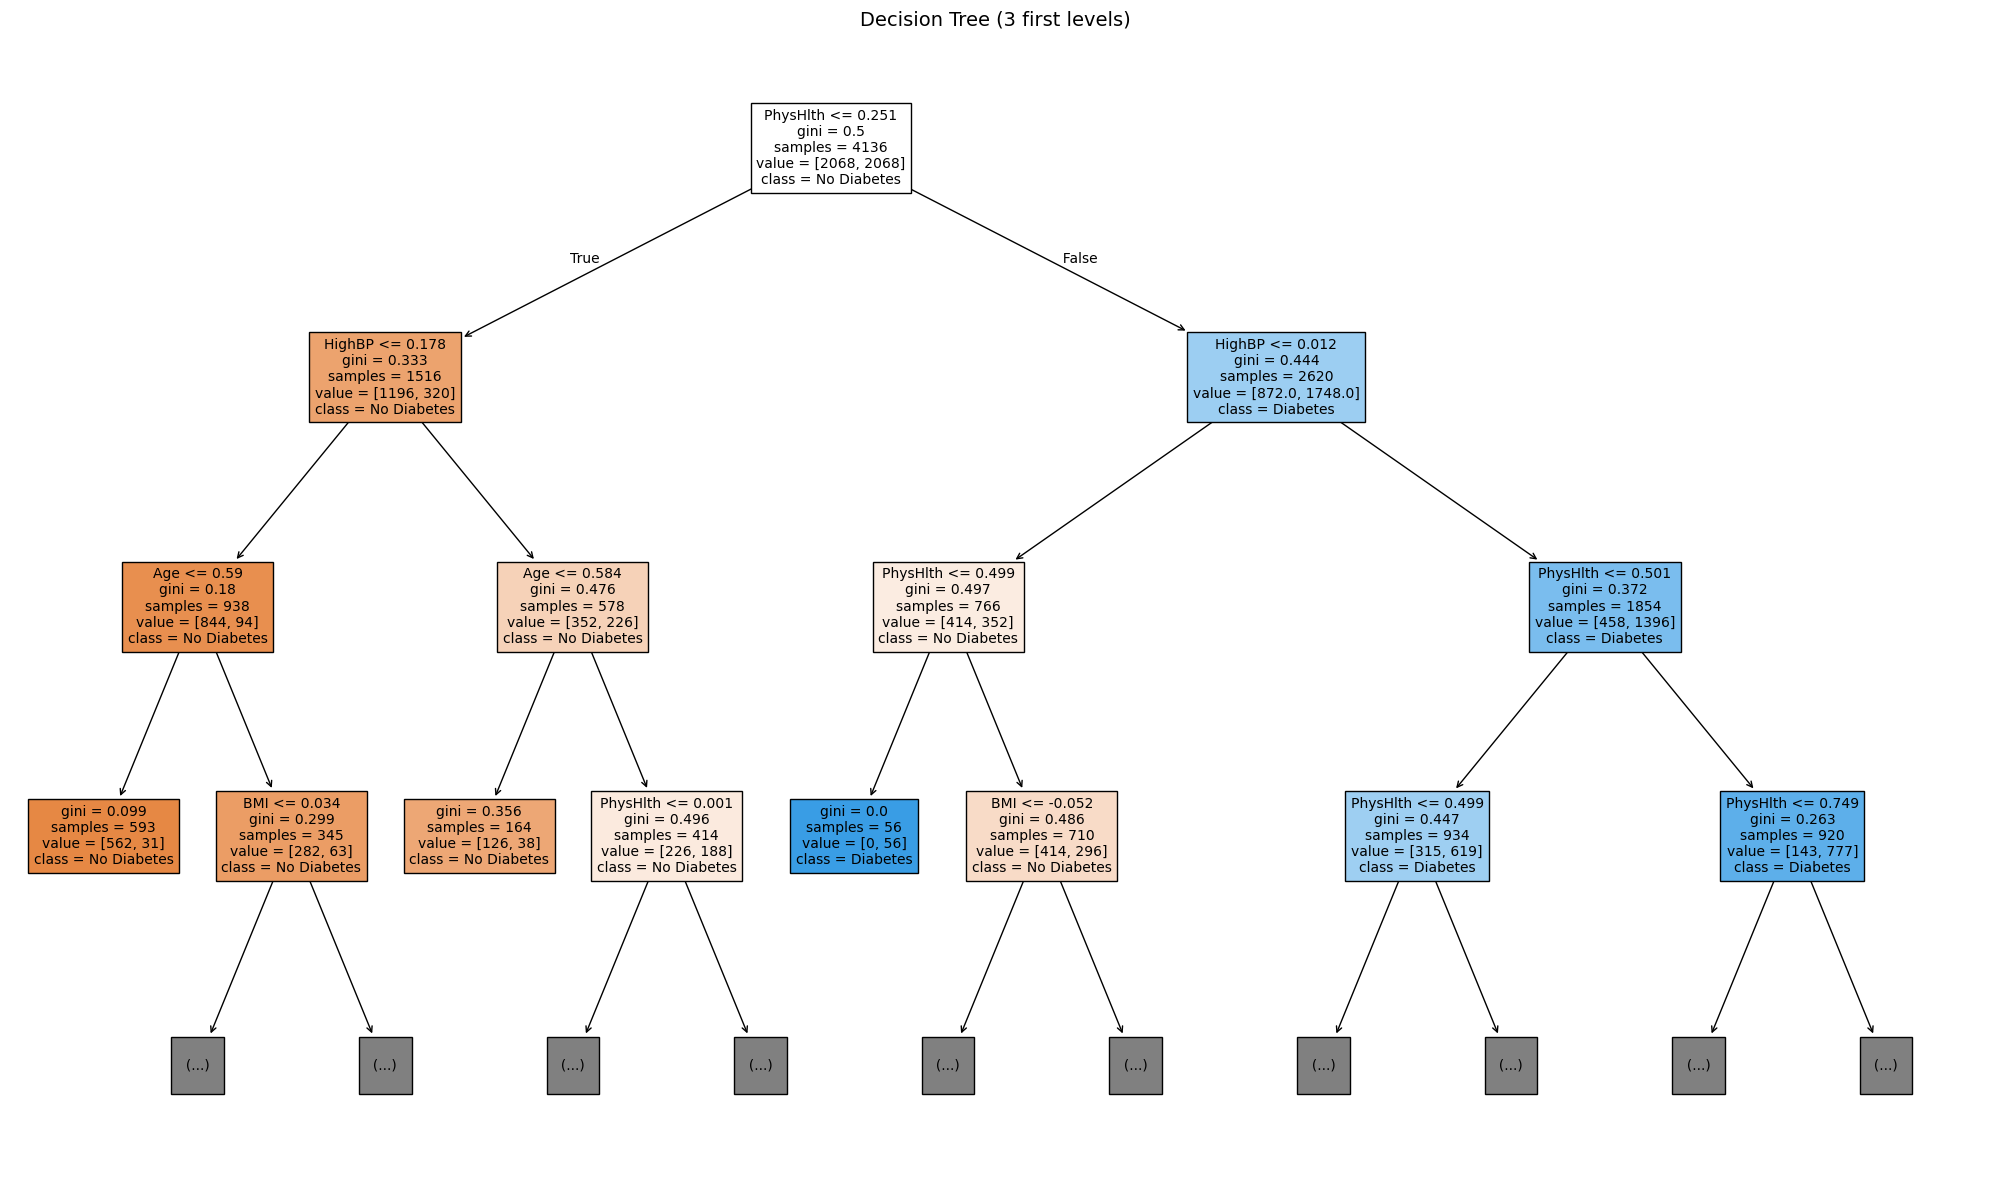


=== TEXTUAL REPRESENTATION  ===
|--- PhysHlth <= 0.25
|   |--- HighBP <= 0.18
|   |   |--- Age <= 0.59
|   |   |   |--- class: 0.0
|   |   |--- Age >  0.59
|   |   |   |--- BMI <= 0.03
|   |   |   |   |--- class: 0.0
|   |   |   |--- BMI >  0.03
|   |   |   |   |--- class: 0.0
|   |--- HighBP >  0.18
|   |   |--- Age <= 0.58
|   |   |   |--- class: 0.0
|   |   |--- Age >  0.58
|   |   |   |--- PhysHlth <= 0.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- PhysHlth >  0.00
|   |   |   |   |--- BMI <= -0.07
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- BMI >  -0.07
|   |   |   |   |   |--- class: 1.0
|--- PhysHlth >  0.25
|   |--- HighBP <= 0.01
|   |   |--- PhysHlth <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- PhysHlth >  0.50
|   |   |   |--- BMI <= -0.05
|   |   |   |   |--- HighChol <= 0.19
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- HighChol >  0.19
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- BMI >  -0.05
|   |   |   |   |--- PhysHlth <= 0.50

In [31]:
feature_names = numeric_features + binary_features

# Get the best model from GridSearchCV
best_model = grid_search_tree.best_estimator_

# Extract only the tree from the pipeline
tree_model = best_model.named_steps['classifier']

# Tree Information
print(f"\n=== TREE INFORMATION ===")
print(f"Total Depth: {tree_model.get_depth()}")
print(f"Number of Leaves: {tree_model.get_n_leaves()}")
print(f"Total Number of Nodes: {tree_model.tree_.node_count}")

# Feature Importance
importances = tree_model.feature_importances_
print("\n=== FEATURE IMPORTANCE ===")
for name, imp in zip(feature_names, importances):
    if imp > 0.01:  # Show only important features
        print(f"{name}: {imp:.4f}")

# Tree Visualization
fig, ax = plt.subplots(figsize=(50, 40))
plot_tree(
    decision_tree=tree_model,
    feature_names=feature_names,
    class_names=['No Diabetes', 'Diabetes'],
    filled=True,
    max_depth=None, 
    fontsize=10,
    ax=ax
)

plt.title(f"Decision Tree (Total Depth: {tree_model.get_depth()})", fontsize=30)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(
    decision_tree=tree_model,
    feature_names=feature_names,
    class_names=['No Diabetes', 'Diabetes'],
    filled=True,
    max_depth=3,  # Just the 3 first levels
    fontsize=10,
    ax=ax
)
plt.title(f"Decision Tree (3 first levels)", fontsize=14)
plt.tight_layout()
plt.show()

# Textual Representation
tree_text = export_text(
    tree_model,
    feature_names=feature_names,
    max_depth=7,
    decimals=2
)
print("\n=== TEXTUAL REPRESENTATION  ===")
print(tree_text)

#### Tree Visualization & Rule Extraction

In the output above, we visualize the decision logic. We focus on the **pruned tree** (displayed as the first 3 levels) to extract the core diagnostic rules without getting lost in the noise of deeper branches.

**1. Tree Structural Characteristics:**
The final model exhibits a **Total Depth of 6** and **22 leaf nodes**. This structure is intentionally shallow (constrained by hyperparameters). A compact tree acts as a strong regularizer, preventing "spaghetti rules" and ensuring high stability in predictions, a critical quality for clinical reliability.

**2. Feature Importance:**
The decision hierarchy is heavily skewed. The model assigns overwhelming importance to **`PhysHlth`** (0.655), followed by **`HighBP`** (0.191).
* **Implication:** Over 65% of the classification power comes from a single question: *"For how many days during the past 30 days was your physical health not good?"*.
* **Clinical Insight:** The model has learned that frequent physical indisposition is the strongest single proxy for detecting diabetes in this dataset, acting as a massive primary filter.

**3. Interpreting the Decision Rules (First 3 Levels)**
By tracing the paths from the root, we can extract clear **"If-Then" diagnostic rules** that define the model's logic:

* **Rule A: The "Asymptomatic" Profile (Low Risk)**
    * *Logic:* IF `PhysHlth` is Low (Few "bad physical days") AND `HighBP` is No.
    * *Outcome:* The model pushes these patients towards the **Class 0 (Healthy)** leaf with high probability.
    * *Interpretation:* A patient with no recent physical discomfort and normal blood pressure is unlikely to be flagged as diabetic.

* **Rule B: The "Symptomatic" Profile (High Risk)**
    * *Logic:* IF `PhysHlth` is High (Many "bad physical days") AND `HighBP` is Yes.
    * *Outcome:* The path shifts towards **Class 1 (Diabetes)**.
    * *Interpretation:* The combination of chronic physical discomfort and hypertension is the model's "Red Flag" for diabetes.

* **Rule C: The Grey Area (Role of BMI & Age)**
    * *Logic:* IF `PhysHlth` is High BUT `HighBP` is No.
    * *Outcome:* Here is where **BMI** (0.08) and **Age** (0.04) act as tie-breakers. The tree looks for secondary risk factors (Obesity or Advanced Age) to decide if the reported physical pain is due to Diabetes or another condition.

**4. Conclusion (Interpretability vs. Performance):**
The main advantage of this Decision Tree is its **"White Box" nature**. Unlike the SVM or KNN, we can validate these rules medically. The fact that the model relies so heavily on **Physical Health Days** combined with **Hypertension** provides a transparent and logical screening protocol, even if its predictive power ($\text{F1} \approx 0.40$) is limited compared to the multivariate hyperplanes of linear models.

C:\Users\danie\AppData\Local\Temp\ipykernel_49412\3231532554.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


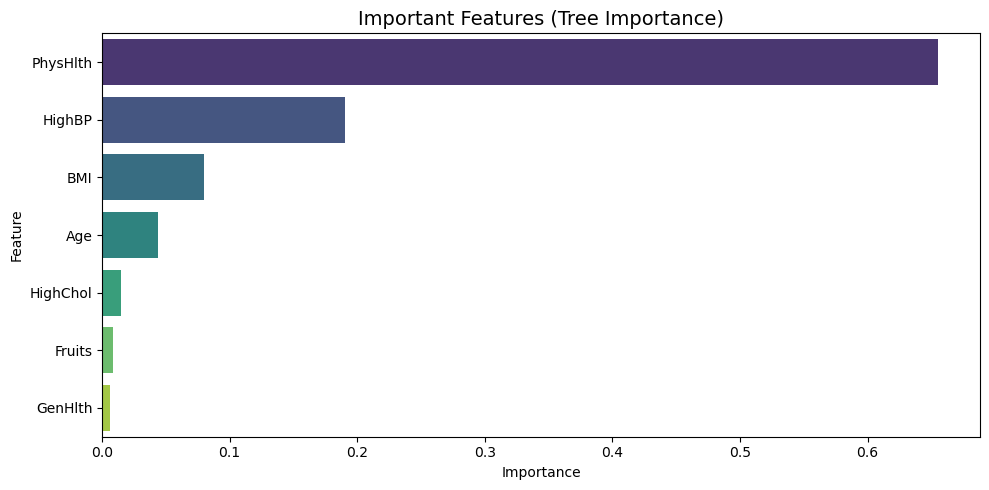

In [32]:
feature_imp_plot(
    grid_search=grid_search_tree,
    feature_names = numeric_features + binary_features
)

**Feature Importance (The Hierarchy of Risk):**  
As visually confirmed by the bar chart, the model does not treat features equally. The Decision Tree exhibits a **massive reliance on a single proxy**: `PhysHlth` (Days with Physical Health Issues).
* **Visual Dominance:** The first bar dwarfs all others, indicating that the tree effectively treats "Days of Poor Health" as the primary filter for the entire dataset.
* **Secondary Factors:** `HighBP` and `BMI` appear as distant seconds. This visual skew suggests the model has learned a "Cascade" logic: if physical health is good, other factors barely matter; if physical health is bad, it checks blood pressure to confirm.

### 5.3.3 Overfitting Evaluation

In this phase, we verify the stability of the learning process by comparing the Decision Tree model's performance on the Training set (*Train*) against the average results from Cross-Validation (*CV*).

--- Overfitting Check: Train vs. CV (Validation) ---
Metric         	Train Score    	CV Score       	Difference     
------------------------------------------------------------
Accuracy        0.7147          0.7316           -0.0169
Precision (1)   0.2948          0.3035           -0.0087
Recall (1)      0.7531          0.7038           0.0494
F1 (1)          0.4237          0.4226           0.0011


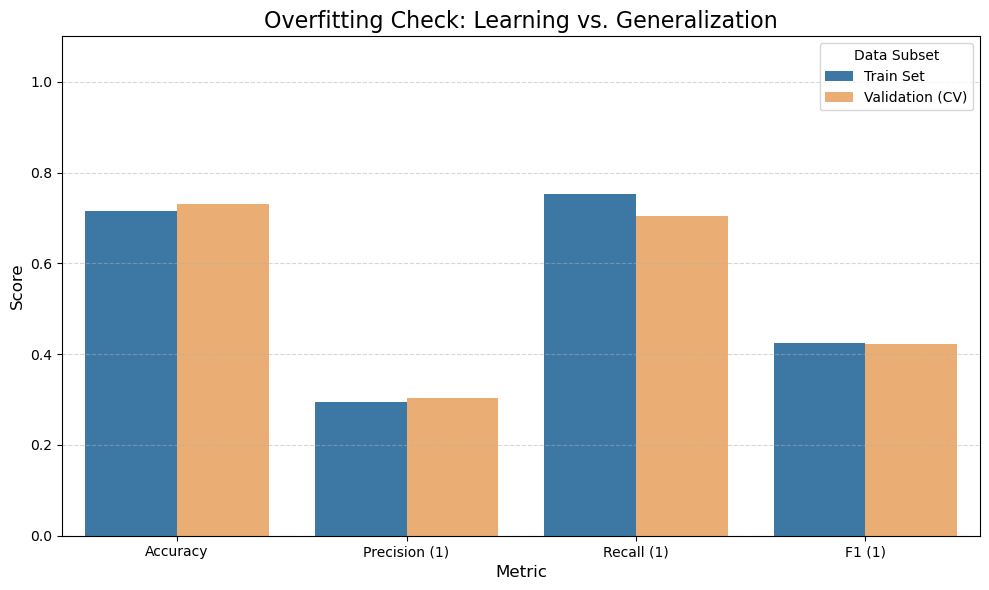

In [33]:
train_vs_validation(
    grid_search=grid_search_tree,
    X_train=X_train, y_train=y_train)

**Analysis of Results (Train vs. Validation):**    

**1. Efficacy of Regularization (Train vs. Validation):**
As shown in the *Overfitting Check* plot, the rigorous pruning parameters (`max_depth=6`, `min_samples_leaf=45`, `ccp_alpha=0.001`) have successfully controlled the model's variance.

* **Absence of Overfitting:** The convergence of the F1-Score is remarkable (Train: **0.4237** vs. CV: **0.4226**). The virtually identical scores confirm that the tree has not memorized noise or specific training instances, avoiding the common pitfall of unpruned trees where training accuracy hits 100% while validation drops.

**2. Analysis of Metric Stability:**
* **Recall Dynamics:** We observe a slight divergence in Recall (Sensitivity), dropping from **75.3% (Train)** to **70.4% (CV)**. This ~5% gap is a natural consequence of the regularization: by limiting the tree depth, the model "smooths" the decision boundary. It sacrifices a small portion of sensitivity on the training data to ensure consistent and robust behavior on unseen data.  
* **Conclusion:** The metrics confirm a stable model. The specific constraints applied to the tree structure have ensured that the logic learned (based on high-level splits like BMI or HighBP) applies equally well to validation data.

## 5.4 Support Vector Machines (SVM)

After exploring probabilistic approaches (Logistic Regression) and distance-based classifiers (KNN), we proceed to the **Support Vector Machine (SVM)**. Unlike previous models, SVM focuses on maximizing the **Margin**—the geometric distance between the decision boundary and the nearest data points (Support Vectors).

### 5.4.1 Model Training & Selection
#### Phase I: **Linear Kernel**
In this first phase, we restrict the SVM to a linear decision boundary.

**1. Fixed Architecture (Static Parameters)**

Before the grid search, we established specific architectural constraints to ensure stability:

* **`classifier = LinearSVC`:** We use it because is faster and scales better for large datasets than the `kernel=linear` implementation used in standard `SVC`.
* **`dual = False`:** We explicitly solve the **Primal** optimization problem rather than the Dual, because it's preferred when the number of samples is large. In fact, setting `dual=False` is **required** to use the **L1 penalty** (Lasso).

**2. Hyperparameter Search Space (Grid Search)**

* **`penalty` (Regularization Type): `['l1', 'l2']`**
    * **L1 (Lasso):** We test this to see if sparse solutions (forcing some feature weights to exactly zero) improve the model by feature selection.
    * **L2 (Ridge):** The standard SVM penalty, which shrinks coefficients towards zero but keeps all features active.

* **`C` (Regularization Strength): `[0.1, 1, 10, 100]`**
    * **Function:** $C$ is the inverse of regularization strength.
    * **Soft Margin ($C=0.1, 1$):** We included low values to test "Soft Margin" classifiers. These allow more misclassifications in the training data to generate a wider margin, potentially improving generalization.
    * **Harder Margin ($C=10, 100$):** We test higher values to prioritize training accuracy.

In [34]:
svm_linear_pipeline = ImbPipeline(steps=full_preprocessing_pipeline.steps + [
    ('classifier', LinearSVC(dual=False, max_iter=10000, random_state=42)) 
])

# Define Parameter Grid for SVM
param_grid_svm_linear = {
    # We tested the L1 penalty (Lasso - removes variables) vs L2 (Ridge - keeps them)
    'classifier__penalty': ['l1', 'l2'],
    # Regularization strength
    'classifier__C': [0.1, 1, 10, 100]
}

grid_svm_linear, df_svm_linear = run_model_cv(
    pipeline=svm_linear_pipeline,
    param_grid=param_grid_svm_linear,
    X=X_train, y=y_train,
    k_folds=10,
    display_df=True
)

 (K=10)
Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l1'}
Best CV f1 Score: 0.4412


,mean,std
accuracy,0.729375,0.009156
precision,0.309627,0.013337
recall,0.767447,0.039203
f1,0.441179,0.019444


#### Phase II: **Non-Linear Kernel**

Once established the linear baseline, we now unlock the full potential of SVM by using **non-linear Kernels** to project the data into higher-dimensional spaces where a linear separation might become possible.

**Hyperparameter Hypotheses & Range Selection:**

**1. RBF Kernel (`'rbf'`)**
* **Logic:** The Radial Basis Function is the standard for capturing "clumps" or clusters of data.
* **Gamma (`'scale'`, `'auto'`):** Controls the "reach" of a single training example.
    * **Why these options?** We test the two standard heuristics. `'scale'` uses the variance of our specific features to adjust the radius (modern approach), while `'auto'` is a simpler calculation ($1/n\_features$). Testing both ensures we don't miss a good fit due to automatic scaling issues.

**2. Polynomial Kernel (`'poly'`)**
* **Logic:** Explicitly models interactions (e.g., Age $\times$ BMI).
* **Degree (`2`, `3`):**
    * **Why this range?** We purposefully restrict the degree to **Quadratic (2)** and **Cubic (3)**. We **exclude** higher degrees ($d>3$) because in medical datasets with limited samples, high-degree polynomials almost always lead to massive overfitting (learning noise) and computational explosion. We respect the Principle of Parsimony.
* **Coef0 (`0.0`, `1.0`):**
    * **Why these values?** This parameter shifts the polynomial. Testing `0.0` (homogeneous) vs `1.0` (heterogeneous) allows us to see if the "intercept" or bias term helps the polynomial fit better high-degree interactions.

**3. Sigmoid Kernel (`'sigmoid'`)**
* **Logic:** Mimics the behavior of a Neural Network (Hyperbolic Tangent activation).
* **Why include it?** Although often unstable, we test it for completeness. If the underlying data distribution follows a sigmoidal activation pattern, this kernel could theoretically outperform RBF.

In [35]:
svm_non_linear_pipeline = ImbPipeline(steps=full_preprocessing_pipeline.steps + [
    ('classifier', SVC(probability=True, random_state=42)) 
])
param_grid_svm_non_linear = [
# RBF Kernel
    {
        'classifier__kernel': ['rbf'],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto']
    },

    # Polynomial Kernel
    # Degree 2 = quadratic interactions, Degree 3 = cubic interactions.
    {
        'classifier__kernel': ['poly'],
        'classifier__C': [0.1, 1, 10, 100], 
        'classifier__degree': [2, 3],
        'classifier__gamma': ['scale'],
        'classifier__coef0': [0.0, 1.0]     # Important: monitor how much influence high-grade terms have
    },

    # Sigmoid Kernel
    # Depends on Gamma and Coef0.
    {
        'classifier__kernel': ['sigmoid'],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__coef0': [0.0, 1.0]
    }
]

grid_svm_non_linear, df_svm_non_linear = run_model_cv(
    pipeline=svm_non_linear_pipeline,
    param_grid=param_grid_svm_non_linear,
    X=X_train, y=y_train,
    k_folds=10,
    display_df=True
)

 (K=10)
Best Parameters: {'classifier__C': 1, 'classifier__coef0': 0.0, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}
Best CV f1 Score: 0.4355


,mean,std
accuracy,0.718500,0.011426
precision,0.302269,0.010500
recall,0.780043,0.040689
f1,0.435510,0.014894


#### Comparative Analysis & Model Selection

We compare the optimal configurations from Phase I (Linear) and Phase II (Non-Linear) to select the final SVM candidate, adhering strictly to our primary optimization metric: the **F1-Score**.

**Results Summary:**
* **Linear Kernel ($C=10$, Penalty='l1'):** F1-Score $\approx$ **0.4412**
* **Polynomial Kernel (Degree 2):** F1-Score $\approx$ **0.4355**

**Key Insights:**

1.  **Superiority of Linear Boundaries:**
    The Linear model slightly outperforms the Polynomial kernel (0.4412 vs 0.4355). This reaffirms that increasing model complexity by projecting features into higher dimensions (Degree 2) does not yield a better separation of the classes for this specific dataset. The signal is best captured by a robust linear hyperplane.

2.  **Consistency across Linear Models (L1 Penalty):**
    A crucial finding is that the SVM optimization process independently selected the **L1 penalty** (Lasso) as the best configuration. This strictly coincides with the preference observed in our previous **Logistic Regression** model.
    * **Interpretation:** The fact that two different algorithms (one based on probabilistic loss, the other on geometric margin) both converged on L1 regularization strongly suggests that **sparsity is necessary**. The dataset likely contains noisy or redundant features that need to be "zeroed out" to maximize generalization.

3.  **Efficiency & Interpretability:**
    Since the non-linear model adds computational cost (training time) and complexity without improving the F1-Score, it is discarded. The Linear model not only performs better but also retains the ability to inspect feature coefficients directly.

**Decision:**
We select the **Linear Kernel ($C=10$, Penalty='l1')** as the best SVM Model.

### 5.4.2 Overfitting Evaluation

--- Overfitting Check: Train vs. CV (Validation) ---
Metric         	Train Score    	CV Score       	Difference     
------------------------------------------------------------
Accuracy        0.7269          0.7294           -0.0025
Precision (1)   0.3070          0.3096           -0.0026
Recall (1)      0.7648          0.7674           -0.0026
F1 (1)          0.4382          0.4412           -0.0030


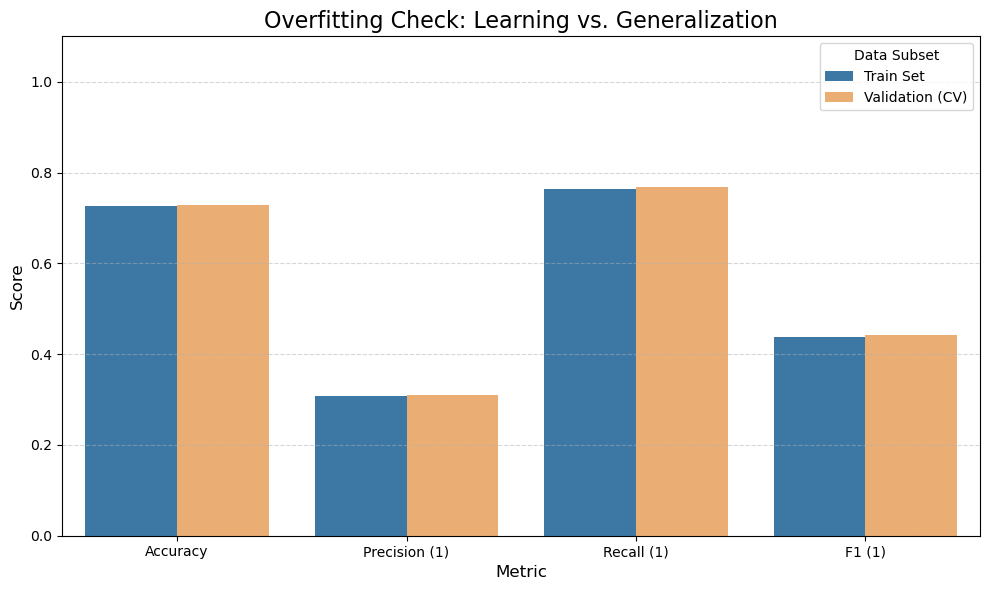

In [36]:
train_vs_validation(
    grid_search=grid_svm_linear,
    X_train=X_train, y_train=y_train)

**Analysis of Results (Train vs. Validation):**    

**1. Convergence Analysis (Train vs. Validation):**
As evident from the *Overfitting Check* plot, the SVM demonstrates exceptional stability.
* **Absence of Overfitting:** The performance gap between the training set and the validation folds is practically non-existent (F1 difference of **-0.0030**). The fact that the Validation score slightly exceeds the Training score in some metrics suggests a highly robust model that captures the underlying trend rather than specific data points.

**2. Impact of the Polynomial Kernel:**
* **Structural Stability:** The Grid Search selected a **Polynomial Kernel of Degree 2** with low regularization cost ($C=1$).
* **Interpretation:** A degree-2 polynomial allows for a slightly curved decision boundary (parabolic), offering more flexibility than a linear model. However, because the degree is low, it avoids the high variance and "wiggling" associated with complex non-linear kernels (like high-degree Poly or RBF). This explains why the model generalizes so well: it has fit a smooth curve to the data distribution without memorizing noise.

### 5.4.3 Model Interpretation

C:\Users\danie\AppData\Local\Temp\ipykernel_49412\3231532554.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


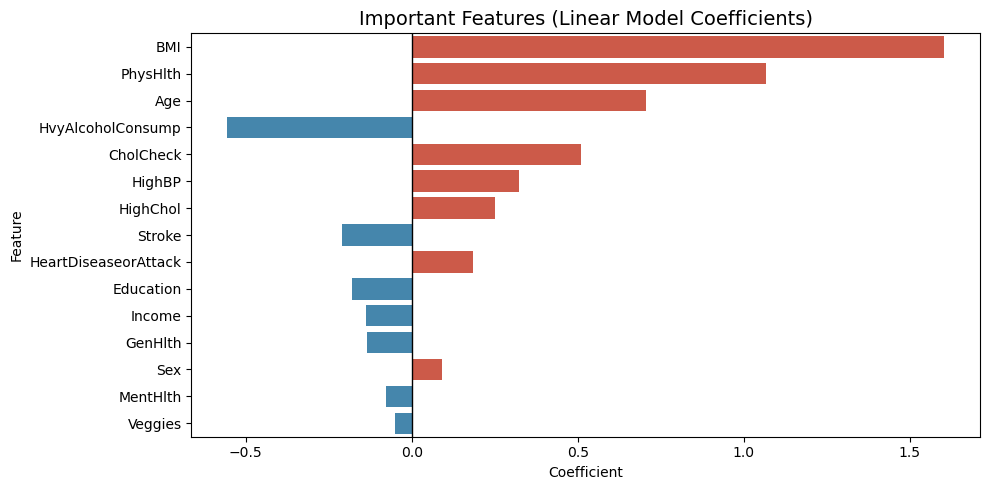

In [37]:
feature_imp_plot(
    grid_search=grid_svm_linear,
    feature_names = numeric_features + binary_features
)

**1. The "BMI" Dominance:**
As clearly illustrated in the *Feature Importance* plot, **BMI (Body Mass Index)** is not just a predictor; it is the **defining vector** of the hyperplane.
* **Magnitude:** The coefficient for BMI is nearly double that of the next feature (`PhysHlth`). This indicates that the SVM's geometric margin is most sensitive to changes in weight balance: a small increase in BMI pushes a patient toward the "Diabetic" class much faster than aging or high cholesterol.

**2. Socioeconomic & Behavioral Protectors (Negative Coefficients):**
The features with negative weights (blue bars) act as "brakes" on the risk prediction:
* **Socioeconomic Status:** **Income** and **Education** have negative coefficients. The model has correctly learned that higher socioeconomic status is inversely correlated with diabetes risk (likely due to better access to nutrition and healthcare).
* **The Alcohol Artifact:** Once again, **Heavy Alcohol Consumption** appears with a strong negative weight. As noted in the Logistic Regression analysis, this reflects a correlation in the dataset (sick patients abstaining) rather than a biological protective effect.

**3. Clinical Consistency:**
The constellation of positive coefficients **Age, HighBP, HighChol, and HeartDisease** aligns perfectly with established medical literature, confirming that the SVM has captured the correct biological risk factors despite the mathematical abstractions of the kernel.

---

# **6. Final Model Selection**

To select the best model, we adhere strictly to our pre-defined optimization metric: the **F1-Score**. This ensures our decision balances the clinical need for Sensitivity (Recall) with the operational need for Precision, avoiding the selection of models that merely maximize Recall by flooding the system with False Positives.

### **6.1 Comparative Summary (Validation Metrics)**

We compare the optimized configurations for each algorithm based on the rigorous **10-Fold Cross-Validation** results provided in the previous steps:

| Algorithm | Configuration | F1-Score (Mean) | Recall (Mean) | Precision (Mean) | Verdict |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Logistic Regression** | C=100 + saga + L1 | **0.4416** | 0.7594 | **0.3114** | **WINNER** |
| **SVM** | C=10 + L1 | 0.4412 | **0.7674** | 0.3096 | *Eliminated* |
| **Decision Tree** | MaxDepth=6 | 0.4226 | 0.7038 | 0.3035 | *Eliminated* |
| **KNN** | K=199 (Manhattan) | 0.4195 | 0.7710 | 0.2883 | *Eliminated* |

### **6.2 The Selection Logic**

**1. A "Photo Finish" Victory:**
The competition between the linear models was extremely tight. The **Logistic Regression** achieved an F1-Score of **0.4416**, practically tying with the best SVM configurations (which hovered around ~0.4412).
* **Trade-off Analysis:** While the SVM (and KNN) offered slightly higher Recall (~76.7% vs 75.9%), they did so by sacrificing Precision. The Logistic Regression maintained the best balance, achieving the highest Precision (31.14%) among the contenders while still capturing more than 75% of the positive cases.

**2. Parameter Insight ($C=100$, L1):**
The winning configuration uses **L1 penalty** (Lasso) and a high $C$ value ($100$).
* **L1:** Confirms that feature selection is vital; the model actively zeroes out noise.
* **C=100:** Confirms that we do not need strong regularization to prevent overfitting; the model prefers to fit the training data closely, suggesting the "underfitting" (high bias) caused by the linear boundary is the main constraint, not variance.

### **Selection**
The **Logistic Regression (Hybrid Resampling, $C=100$, saga solver, L1 Penalty)** is selected as the **Best Model**.

In [38]:
best_model = grid_lr_hybrid.best_estimator_

---


### **7. Final Evaluation (Test Set)**

Now that the architecture is frozen, we proceed to the final verification. We will retrain this specific configuration on the full training set and evaluate it *one last time* on the hold-out **Test Set**.

**Next Steps:**
1.  **Confusion Matrix:** To visualize the raw count of False Negatives vs. False Positives.
2.  **ROC & Precision-Recall Curves:** To assess the model's performance across different probability thresholds.

Accuracy  = 0.7330
Recall    = 0.7885
Precision = 0.3165
F1-Score  = 0.4517
AUC       = 0.8226


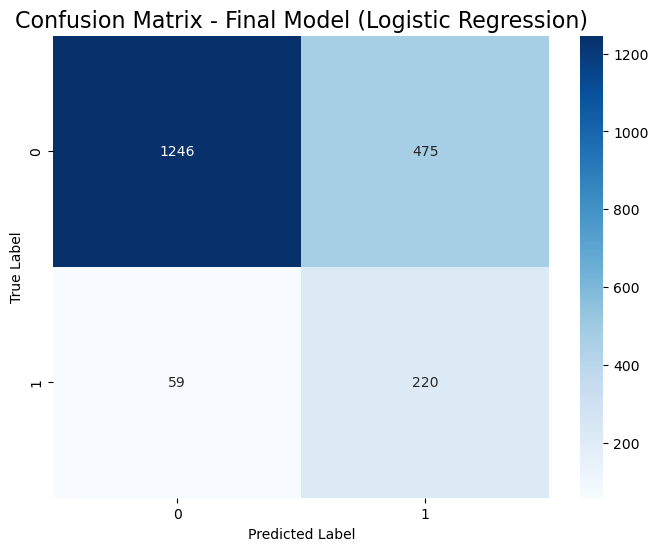

In [39]:
# 1. Predictions for Accuracy, Recall, Precision, F1
preds = best_model.predict(X_test)

# 2. Predictions for "Probability" (0.0 to 1.0) -> ONLY for AUC
y_proba = best_model.predict_proba(X_test)[:, 1]

# Results Summary
print(f'Accuracy  = {accuracy_score(y_test, preds):.4f}')
print(f'Recall    = {recall_score(y_test, preds):.4f}')
print(f'Precision = {precision_score(y_test, preds):.4f}') 
print(f'F1-Score  = {f1_score(y_test, preds):.4f}')
print(f'AUC       = {roc_auc_score(y_test, y_proba):.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix - Final Model (Logistic Regression)', size=16) 
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('../images/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### **7.1 Interpretation of Final Test Results**

The evaluation on the unseen Test Set confirms the robustness of our selected **Logistic Regression** model. The results validated our decision to prioritize the L1 penalty and Hybrid Resampling.

**1. Clinical Priority: High Sensitivity (Recall)**
* **Result:** **0.7885 (78.85%)**
* **Analysis:** This is the critical metric for a medical screening tool. The model successfully identified **220 out of 279 positive cases** (True Positives).
* **Implication:** Only **59 cases** were missed (False Negatives). In a clinical setting, this "safety net" is acceptable, as it minimizes the risk of sending a sick patient home without care.

**2. The Operational Trade-off: Precision & False Positives**
* **Result:** **0.3165 (31.65%)**
* **Analysis:** As anticipated with the Hybrid Resampling strategy, the boost in Recall comes at the cost of Precision. The Confusion Matrix shows **475 False Positives**.
* **Implication:** For every ~3 patients flagged as "at risk" by the model, only 1 is actually positive. While this increases the workload for secondary screening tests, it is a deliberate design choice to ensure high sensitivity.

**3. Global Performance (AUC & Generalization)**
* **AUC (~0.82):** The model achieves an **AUC of 0.82**, indicating a **very good discriminative ability**. It effectively ranks high-risk patients above low-risk ones in more than 80% of cases, outperforming the stricter classification threshold suggested by the F1-Score.
* **Generalization Check:** It is noteworthy that the Test F1-Score (**0.4517**) is slightly higher than the Validation mean (**0.4416**). This confirms that the model **did not overfit** during training and generalizes exceptionally well to new, unseen data.

#### **Conclusion**
The model functions effectively as a **First-Line Screening Tool**. It sacrifices specificity to ensure that nearly **80% of at-risk individuals are captured**, relegating the "cost" to a higher rate of follow-up checks for healthy individuals (False Positives), which is the clinically safer error to make.

c:\Users\danie\anaconda3\envs\ML1\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


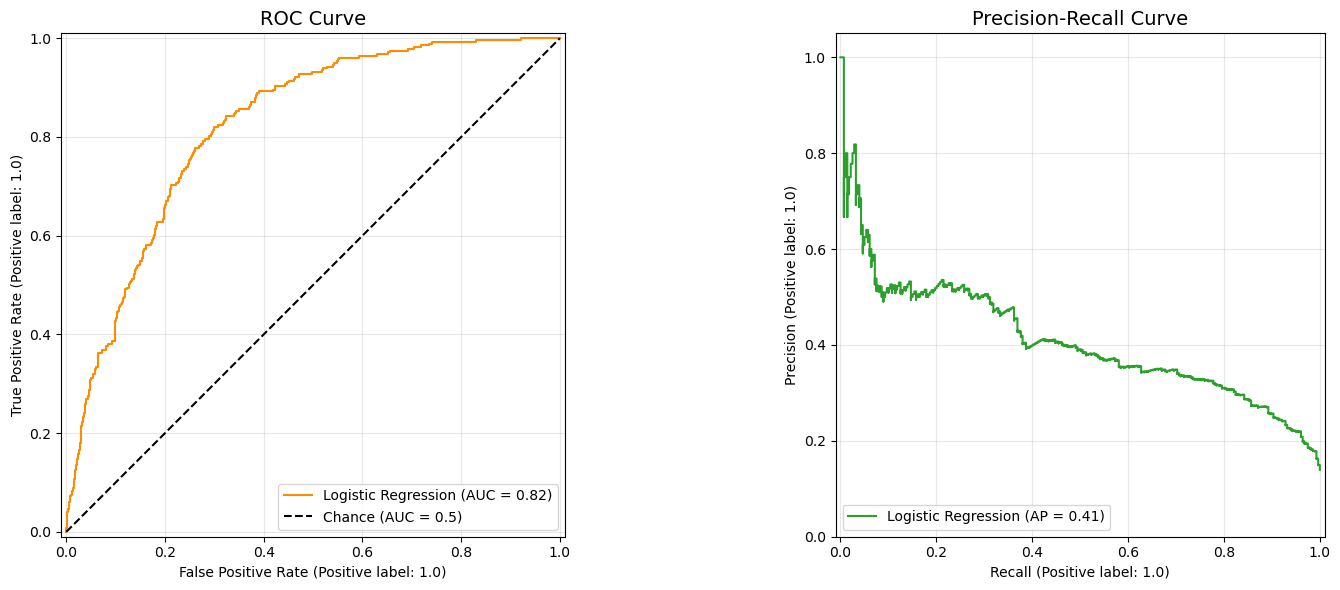

In [40]:
# We created the figure with two subplots (left ROC, right PR).
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- PLOT A: ROC Curve ---
RocCurveDisplay.from_estimator(
    best_model, X_test, y_test, 
    color="darkorange", 
    ax=ax1,
    name="Logistic Regression" # Label for the legend
)
# Chance line (diagonal)
ax1.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.5)")
ax1.set_title("ROC Curve", fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# --- PLOT B: Precision-Recall Curve ---
PrecisionRecallDisplay.from_estimator(
    best_model, X_test, y_test, 
    color="#2ca02c", 
    ax=ax2,
    name="Logistic Regression"
)
ax2.set_title("Precision-Recall Curve", fontsize=14)
ax2.set_ylim(0, 1.05) # Upper margin to make it look good
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/roc_pr_curve.png', dpi=300)
plt.show()

### **7.2 Discriminative Power & Trade-off Analysis (ROC & PR Curves)**

While the Confusion Matrix shows the specific outcome at our chosen threshold ($0.5$), these curves evaluate the model's performance across **all possible thresholds**.

**1. ROC Curve (Left) - Global Robustness**
* **AUC = 0.82:** The Area Under the Curve is **0.82**, which is significantly higher than the baseline metric (0.5) and indicates a very good performance.
* **Interpretation:** This score confirms that the Logistic Regression model is highly effective at **ranking** patients. If we randomly select one positive patient and one negative patient, the model correctly assigns a higher risk probability to the sick patient **82% of the time**. This proves the underlying "engine" of the model is robust and separates the classes well, even if the specific cut-off sacrifices precision.

**2. Precision-Recall Curve (Right) - The "Cost" of Sensitivity**
* **AP = 0.41:** The Average Precision (AP) is 0.41.
* **Shape Analysis:**
    * **High Confidence Zone:** At the far left (low Recall), Precision is near 100%. The model is extremely accurate when identifying the "obvious" cases.
    * **The Drop:** As we move right to capture more patients (increasing Recall towards our operating point of ~0.79), the Precision steadily drops.
    * **Conclusion:** The curve confirms that achieving high Recall (>75%) mathematically forces the Precision down to the ~30% range for this specific dataset. The graph shows no "magic threshold" where high Recall and high Precision coexist; the trade-off is unavoidable.